In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
import numpy as np
from pprint import pprint
from tqdm.auto import tqdm
from tqdm import tqdm_notebook
from scipy.sparse import hstack
from collections import defaultdict, Counter
from ds_tools.ds_tools import CategoricalTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
tqdm.pandas()

In [2]:
df_description = pd.read_csv('./data/data_definition.txt', sep='\t')

df_train_genba = pd.read_csv('./data/train_genba.tsv', sep='\t')
df_train_goto = pd.read_csv('./data/train_goto.tsv', sep='\t')

df_train = df_train_goto.merge(df_train_genba, on='pj_no', how='left')

df_test_genba = pd.read_csv('./data/test_genba.tsv', sep='\t')
df_test_goto = pd.read_csv('./data/test_goto.tsv', sep='\t')

df_test = df_test_goto.merge(df_test_genba, on='pj_no', how='left')
test_surface = df_test['tc_mseki']

df_train.drop(['id', 'kaoku_um', 'toshikuiki2', 'shu_sogi'], axis=1, inplace=True)
df_test.drop(['id', 'kaoku_um', 'toshikuiki2', 'shu_sogi'], axis=1, inplace=True)

continue_features = list(df_description[(df_description['データ型'] == '数値') & (df_description['項目名'] != 'pj_no')]['項目名'])

## Preprocessing

In [3]:
def combine(row, combine_list, tup):
    l = set()
    for col in tup:
        if pd.notnull(row[col]):
            l.add(row[col])
    combine_list.append(','.join(l))

combine_cols = [('yoto', 100), ('road_hk', 100)]
for i, tup in enumerate([['yoto1', 'yoto2'], ['road1_hk', 'road2_hk', 'road3_hk', 'road4_hk']]):
    combine_train = []
    combine_test = []
    
    combine_col_name = combine_cols[i][0]
    _ = df_train.apply(lambda row: combine(row, combine_train, tup), axis=1)
    _ = df_test.apply(lambda row: combine(row, combine_test, tup), axis=1)

    count_vectorizer = CountVectorizer(min_df=combine_cols[i][1])
    combine_train_matrix = count_vectorizer.fit_transform(combine_train).todense()
    combine_test_matrix = count_vectorizer.transform(combine_test).todense()
    for i in range(combine_train_matrix.shape[1]):
        df_train['%s_%d' % (combine_col_name, i)] = combine_train_matrix[:, i]
        df_test['%s_%d' % (combine_col_name, i)] = combine_test_matrix[:, i]
    for col in tup:
        df_train.drop(col, axis=1, inplace=True)
        df_test.drop(col, axis=1, inplace=True)

In [4]:
for col in ['mseki_rd_hb', 'road3_fi', 'rosenka_hb', 'kempei2', 'road2_mg', 'kaoku_hb', 'bus_hon']:
    df_train[col].replace(0.0, np.nan, inplace=True)
    df_test[col].replace(0.0, np.nan, inplace=True)

coordinates = pickle.load(open('./data/coordinates.bin', 'rb'))

for df in [df_train, df_test]:
    df['station_name_prefix'] = df['rosen_nm1'].str.slice(stop=2)
    df.loc[pd.isnull(df['chiseki_kb_hb']) | (df['chiseki_kb_hb'] == 0), 'chiseki_kb_hb'] = df.loc[pd.isnull(df['chiseki_kb_hb']) | (df['chiseki_kb_hb'] == 0), 'chiseki_js_hb']
    df['chiseki_ratio'] = df['chiseki_js_hb']/df['chiseki_kb_hb']
    
    df['lat'] = df['jukyo'].apply(lambda j: coordinates[j]['results'][0]['geometry']['location']['lat'] if coordinates[j]['results'] else np.nan)
    df['lng'] = df['jukyo'].apply(lambda j: coordinates[j]['results'][0]['geometry']['location']['lng'] if coordinates[j]['results'] else np.nan)
    
for col in ['magutchi']:
    col_mean = pd.concat([df_train[col], df_test[col]]).mean()
    df_train[col] = df_train[col].fillna(col_mean)
    df_test[col] = df_test[col].fillna(col_mean)
    
def fill_city_name(name):
    if '市' not in name and '郡' not in name:
        name = '市' + name
    return name

for df in [df_train, df_test]:
    df['jukyo'] = df['jukyo'].str.replace(r'[ヶｹ]', 'ケ')
    df['jukyo'] = df['jukyo'].apply(fill_city_name)
    city_split = df['jukyo'].str.split(r'[市郡]', n=1, expand=True)
    df['city'] = city_split[0]
    street_split = city_split[1].str.split(r'[町区]', n=1, expand=True)
    df['street'] = street_split[0]
    df['address_detail'] = street_split[1].str.strip().str.replace('大字', '').replace('', None)

def make_percentage_features(numeric_feature, categorical_feature):
    global continue_features
    df_combined = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
    mean_label = '%s_to_mean_%s' % (numeric_feature, categorical_feature)
    df_combined[mean_label] = df_combined[numeric_feature] / df_combined.groupby([categorical_feature])[numeric_feature].transform('mean')
    df_train[mean_label] = df_combined[mean_label].iloc[:len(df_train)]
    df_test[mean_label] = df_combined[mean_label].iloc[len(df_train):].reset_index(drop=True)
    continue_features += [mean_label]
    
make_percentage_features('magutchi', 'eki_nm1')
make_percentage_features('tt_mseki', 'eki_nm1')
make_percentage_features('tc_mseki', 'eki_nm1')
make_percentage_features('niwasaki', 'eki_nm1')
make_percentage_features('rosenka_hb', 'eki_nm1')
make_percentage_features('magutchi', 'city')
make_percentage_features('tt_mseki', 'city')
make_percentage_features('tc_mseki', 'city')
make_percentage_features('niwasaki', 'city')
make_percentage_features('rosenka_hb', 'city')

In [5]:
splitter = KFold(n_splits=5, shuffle=True, random_state=28)
price_stats = []
for train_idx, valid_idx in splitter.split(df_train):
    price_stats_by_city = defaultdict(dict)
    for city, group in df_train.iloc[train_idx].groupby('city'):
        price_list = group['keiyaku_pr']/group['tc_mseki']
        price_stats_by_city[city]['price_by_city_mean'] = price_list.mean()
        price_stats_by_city[city]['price_by_city_median'] = price_list.median()
        price_stats_by_city[city]['price_by_city_min'] = price_list.min()
        price_stats_by_city[city]['price_by_city_max'] = price_list.max()
        price_stats_by_city[city]['price_by_city_std'] = price_list.std()
        price_stats_by_city[city]['price_by_city_count'] = len(price_list)
    for i, city in enumerate(df_train.iloc[valid_idx]['city']):
        price_stats.append((valid_idx[i], price_stats_by_city[city]))

price_stats_test = [] 
price_stats_by_city = defaultdict(dict)
for city, group in df_train.groupby('city'):
    price_list = group['keiyaku_pr']/group['tc_mseki']
    price_stats_by_city[city]['price_by_city_mean'] = price_list.mean()
    price_stats_by_city[city]['price_by_city_median'] = price_list.median()
    price_stats_by_city[city]['price_by_city_min'] = price_list.min()
    price_stats_by_city[city]['price_by_city_max'] = price_list.max()
    price_stats_by_city[city]['price_by_city_std'] = price_list.std()
    price_stats_by_city[city]['price_by_city_count'] = len(price_list)
for city in df_test['city']:
    price_stats_test.append(price_stats_by_city[city])
    
df_price_stats = pd.DataFrame([x[1] for x in sorted(price_stats, key=lambda x: x[0])])
df_price_stats_test = pd.DataFrame(price_stats_test)

df_train = pd.concat([df_train, df_price_stats], axis=1)
df_test = pd.concat([df_test, df_price_stats_test], axis=1)

## Train

In [6]:
continue_features += ['price_by_city_mean', 'price_by_city_median', 'price_by_city_min', 'price_by_city_max', 
                      'price_by_city_std', 'price_by_city_count', 'chiseki_ratio', 'lng', 'lat']
objective = 'keiyaku_pr'
categorical_features = list(df_train)

for f in continue_features+[objective]:
    if f in categorical_features:
        categorical_features.remove(f)
        
for col in categorical_features:
    if col not in ['pj_no']:
        df_train[col] = df_train[col].fillna('UNKNOWN')
        df_test[col] = df_test[col].fillna('UNKNOWN')
        le = LabelEncoder()
        le.fit(pd.concat([df_train[col], df_test[col]]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        
for col in continue_features:
    if col != 'keiyaku_pr':
        scaler = MinMaxScaler()
        df_train[col] = scaler.fit_transform(df_train[col].values.reshape(-1, 1))
        df_test[col] = scaler.transform(df_test[col].values.reshape(-1, 1))
    
df_test['keiyaku_pr'] = 0

## LGB

In [7]:
splitter = KFold(n_splits=5, shuffle=True, random_state=28)
prediction_list = []
best_scores = []
feature_importance_list = []
for train_idx, valid_idx in splitter.split(df_train):
    train, valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    X_train, y_train = train.drop('keiyaku_pr', axis=1), np.log(train['keiyaku_pr']-1e6+1)
    X_valid, y_valid = valid.drop('keiyaku_pr', axis=1), np.log(valid['keiyaku_pr']-1e6+1)
    regressor = lgb.LGBMRegressor(n_estimators=100000, learning_rate=0.01, silent=False, random_state=28,
                                  bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.8, lambda_l1=0.05, 
                                  max_depth=6, objective='fair')
    regressor.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=500,
                  categorical_feature=categorical_features)
    prediction_list.append(regressor.predict(df_test[df_train.drop(objective, axis=1).columns]))
    best_scores.append(regressor.best_score_['valid_0']['fair'])
    feature_importance_list.append(regressor.feature_importances_)

print("5-fold cv mean l2 %.8f" % np.mean(best_scores))

df_submission = pd.read_csv('./data/sample_submit.tsv', sep='\t', names=['id', 'pred'])

df_submission['pred'] = np.exp(np.mean(prediction_list, axis=0))-1+1e6
df_submission.to_csv('submission.tsv', sep='\t', header=None, index=False)

# 0.00496071

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['address_detail', 'bas_toho1', 'bas_toho2', 'bastei_nm1', 'bastei_nm2', 'bokachiiki', 'bus_yohi', 'chikukeikaku', 'city', 'eki_nm1', 'eki_nm2', 'fi3m_yohi', 'fi4m_yohi', 'gas', 'gesui', 'hiatari', 'hokakisei1', 'hokakisei2', 'hokakisei3', 'hokakisei4', 'hokakyoka', 'hw_status', 'jigata', 'josui', 'jukyo', 'kaihatsukyoka', 'kborjs', 'keikakuroad', 'kinshijiko', 'kobetsu1', 'kobetsu2', 'kobetsu3', 'kobetsu4', 'kodochiku', 'levelplan', 'pj_no', 'road1_sb', 'road2_sb', 'road3_sb', 'road4_sb', 'road_hk_0', 'road_hk_1', 'road_hk_2', 'road_hk_3', 'road_st', 'rosen_nm1', 'rosen_nm2', 'rs_e_kdate2', 'rs_e_kdate3', 'rs_e_m_ari', 'rs_e_m_nashi', 'rs_e_parking', 'rs_e_tahata', 'rs_e_zoki', 'rs_n_kdate2', 'rs_n_kdate3', 'rs_n_m_ari', 'rs_n_m_nashi', 'rs_n_parking', 'rs_n_tahata', 'rs_n_zoki', 'rs_s_kdate2', 'rs_s_kdate3', 'rs_s_m_ari', 'rs_s_m_nashi',

[1]	valid_0's fair: 0.0276076
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's fair: 0.0272489
[3]	valid_0's fair: 0.0268999
[4]	valid_0's fair: 0.0265536
[5]	valid_0's fair: 0.0262177
[6]	valid_0's fair: 0.0259079
[7]	valid_0's fair: 0.0255951
[8]	valid_0's fair: 0.0252786
[9]	valid_0's fair: 0.0249696
[10]	valid_0's fair: 0.0246753
[11]	valid_0's fair: 0.0243852
[12]	valid_0's fair: 0.0241045
[13]	valid_0's fair: 0.0238237
[14]	valid_0's fair: 0.0235513
[15]	valid_0's fair: 0.0232833
[16]	valid_0's fair: 0.0230227
[17]	valid_0's fair: 0.022764
[18]	valid_0's fair: 0.0225056
[19]	valid_0's fair: 0.0222526
[20]	valid_0's fair: 0.0220155
[21]	valid_0's fair: 0.0217845
[22]	valid_0's fair: 0.0215599
[23]	valid_0's fair: 0.021341
[24]	valid_0's fair: 0.0211138
[25]	valid_0's fair: 0.0209081
[26]	valid_0's fair: 0.0206956
[27]	valid_0's fair: 0.0204904
[28]	valid_0's fair: 0.0202856
[29]	valid_0's fair: 0.020085
[30]	valid_0's fair: 0.0198905
[31]	valid_0's fair

[305]	valid_0's fair: 0.00777846
[306]	valid_0's fair: 0.00777305
[307]	valid_0's fair: 0.0077643
[308]	valid_0's fair: 0.00775653
[309]	valid_0's fair: 0.0077484
[310]	valid_0's fair: 0.00774272
[311]	valid_0's fair: 0.00773536
[312]	valid_0's fair: 0.0077255
[313]	valid_0's fair: 0.00772017
[314]	valid_0's fair: 0.00771253
[315]	valid_0's fair: 0.00770517
[316]	valid_0's fair: 0.00769818
[317]	valid_0's fair: 0.00769171
[318]	valid_0's fair: 0.00768312
[319]	valid_0's fair: 0.00767754
[320]	valid_0's fair: 0.00767106
[321]	valid_0's fair: 0.00766557
[322]	valid_0's fair: 0.00766059
[323]	valid_0's fair: 0.00765362
[324]	valid_0's fair: 0.00764725
[325]	valid_0's fair: 0.00764123
[326]	valid_0's fair: 0.00763485
[327]	valid_0's fair: 0.00762786
[328]	valid_0's fair: 0.00762043
[329]	valid_0's fair: 0.00761356
[330]	valid_0's fair: 0.00760774
[331]	valid_0's fair: 0.00759901
[332]	valid_0's fair: 0.0075925
[333]	valid_0's fair: 0.00758511
[334]	valid_0's fair: 0.00757904
[335]	valid_0'

[592]	valid_0's fair: 0.00671248
[593]	valid_0's fair: 0.00671085
[594]	valid_0's fair: 0.00670995
[595]	valid_0's fair: 0.0067077
[596]	valid_0's fair: 0.00670595
[597]	valid_0's fair: 0.00670401
[598]	valid_0's fair: 0.0067018
[599]	valid_0's fair: 0.0067009
[600]	valid_0's fair: 0.00669952
[601]	valid_0's fair: 0.00669753
[602]	valid_0's fair: 0.00669518
[603]	valid_0's fair: 0.00669275
[604]	valid_0's fair: 0.00669139
[605]	valid_0's fair: 0.00668907
[606]	valid_0's fair: 0.00668614
[607]	valid_0's fair: 0.00668522
[608]	valid_0's fair: 0.00668319
[609]	valid_0's fair: 0.00668054
[610]	valid_0's fair: 0.00667907
[611]	valid_0's fair: 0.0066769
[612]	valid_0's fair: 0.00667432
[613]	valid_0's fair: 0.00667287
[614]	valid_0's fair: 0.00667129
[615]	valid_0's fair: 0.00666828
[616]	valid_0's fair: 0.00666676
[617]	valid_0's fair: 0.00666414
[618]	valid_0's fair: 0.00666049
[619]	valid_0's fair: 0.00665861
[620]	valid_0's fair: 0.00665593
[621]	valid_0's fair: 0.00665405
[622]	valid_0'

[881]	valid_0's fair: 0.00636792
[882]	valid_0's fair: 0.00636699
[883]	valid_0's fair: 0.00636632
[884]	valid_0's fair: 0.00636578
[885]	valid_0's fair: 0.00636503
[886]	valid_0's fair: 0.00636371
[887]	valid_0's fair: 0.0063627
[888]	valid_0's fair: 0.00636259
[889]	valid_0's fair: 0.00636127
[890]	valid_0's fair: 0.00636039
[891]	valid_0's fair: 0.00635863
[892]	valid_0's fair: 0.00635825
[893]	valid_0's fair: 0.00635828
[894]	valid_0's fair: 0.00635826
[895]	valid_0's fair: 0.00635704
[896]	valid_0's fair: 0.00635549
[897]	valid_0's fair: 0.00635452
[898]	valid_0's fair: 0.00635403
[899]	valid_0's fair: 0.00635382
[900]	valid_0's fair: 0.006353
[901]	valid_0's fair: 0.00635256
[902]	valid_0's fair: 0.00635196
[903]	valid_0's fair: 0.00635077
[904]	valid_0's fair: 0.00635023
[905]	valid_0's fair: 0.00634951
[906]	valid_0's fair: 0.00634853
[907]	valid_0's fair: 0.00634738
[908]	valid_0's fair: 0.00634634
[909]	valid_0's fair: 0.00634541
[910]	valid_0's fair: 0.00634459
[911]	valid_0

[1176]	valid_0's fair: 0.00621098
[1177]	valid_0's fair: 0.00621015
[1178]	valid_0's fair: 0.00621003
[1179]	valid_0's fair: 0.00620983
[1180]	valid_0's fair: 0.0062093
[1181]	valid_0's fair: 0.00620959
[1182]	valid_0's fair: 0.00620927
[1183]	valid_0's fair: 0.00620868
[1184]	valid_0's fair: 0.00620765
[1185]	valid_0's fair: 0.00620658
[1186]	valid_0's fair: 0.00620622
[1187]	valid_0's fair: 0.0062047
[1188]	valid_0's fair: 0.00620447
[1189]	valid_0's fair: 0.00620438
[1190]	valid_0's fair: 0.00620372
[1191]	valid_0's fair: 0.00620338
[1192]	valid_0's fair: 0.00620308
[1193]	valid_0's fair: 0.00620328
[1194]	valid_0's fair: 0.00620264
[1195]	valid_0's fair: 0.00620296
[1196]	valid_0's fair: 0.00620278
[1197]	valid_0's fair: 0.00620274
[1198]	valid_0's fair: 0.00620228
[1199]	valid_0's fair: 0.00620197
[1200]	valid_0's fair: 0.00620117
[1201]	valid_0's fair: 0.00620093
[1202]	valid_0's fair: 0.00620159
[1203]	valid_0's fair: 0.00620196
[1204]	valid_0's fair: 0.00620137
[1205]	valid_0's

[1470]	valid_0's fair: 0.0061257
[1471]	valid_0's fair: 0.00612574
[1472]	valid_0's fair: 0.00612586
[1473]	valid_0's fair: 0.00612565
[1474]	valid_0's fair: 0.0061257
[1475]	valid_0's fair: 0.00612534
[1476]	valid_0's fair: 0.00612478
[1477]	valid_0's fair: 0.00612417
[1478]	valid_0's fair: 0.00612416
[1479]	valid_0's fair: 0.00612325
[1480]	valid_0's fair: 0.00612324
[1481]	valid_0's fair: 0.00612299
[1482]	valid_0's fair: 0.00612293
[1483]	valid_0's fair: 0.00612289
[1484]	valid_0's fair: 0.0061232
[1485]	valid_0's fair: 0.00612219
[1486]	valid_0's fair: 0.00612184
[1487]	valid_0's fair: 0.0061216
[1488]	valid_0's fair: 0.00612145
[1489]	valid_0's fair: 0.00612109
[1490]	valid_0's fair: 0.00612139
[1491]	valid_0's fair: 0.00612133
[1492]	valid_0's fair: 0.00612112
[1493]	valid_0's fair: 0.00612135
[1494]	valid_0's fair: 0.0061212
[1495]	valid_0's fair: 0.00612103
[1496]	valid_0's fair: 0.0061206
[1497]	valid_0's fair: 0.00612023
[1498]	valid_0's fair: 0.00612004
[1499]	valid_0's fai

[1763]	valid_0's fair: 0.00607642
[1764]	valid_0's fair: 0.00607623
[1765]	valid_0's fair: 0.0060761
[1766]	valid_0's fair: 0.00607571
[1767]	valid_0's fair: 0.00607557
[1768]	valid_0's fair: 0.00607516
[1769]	valid_0's fair: 0.00607516
[1770]	valid_0's fair: 0.00607512
[1771]	valid_0's fair: 0.00607581
[1772]	valid_0's fair: 0.00607544
[1773]	valid_0's fair: 0.00607466
[1774]	valid_0's fair: 0.00607464
[1775]	valid_0's fair: 0.00607437
[1776]	valid_0's fair: 0.00607403
[1777]	valid_0's fair: 0.00607371
[1778]	valid_0's fair: 0.00607347
[1779]	valid_0's fair: 0.00607328
[1780]	valid_0's fair: 0.0060728
[1781]	valid_0's fair: 0.00607317
[1782]	valid_0's fair: 0.00607314
[1783]	valid_0's fair: 0.00607303
[1784]	valid_0's fair: 0.00607295
[1785]	valid_0's fair: 0.0060726
[1786]	valid_0's fair: 0.00607258
[1787]	valid_0's fair: 0.00607226
[1788]	valid_0's fair: 0.00607245
[1789]	valid_0's fair: 0.00607233
[1790]	valid_0's fair: 0.00607259
[1791]	valid_0's fair: 0.00607246
[1792]	valid_0's 

[2053]	valid_0's fair: 0.00604249
[2054]	valid_0's fair: 0.00604243
[2055]	valid_0's fair: 0.00604241
[2056]	valid_0's fair: 0.00604271
[2057]	valid_0's fair: 0.00604249
[2058]	valid_0's fair: 0.00604221
[2059]	valid_0's fair: 0.00604199
[2060]	valid_0's fair: 0.00604186
[2061]	valid_0's fair: 0.0060422
[2062]	valid_0's fair: 0.00604195
[2063]	valid_0's fair: 0.00604187
[2064]	valid_0's fair: 0.00604196
[2065]	valid_0's fair: 0.00604209
[2066]	valid_0's fair: 0.0060415
[2067]	valid_0's fair: 0.00604193
[2068]	valid_0's fair: 0.0060417
[2069]	valid_0's fair: 0.00604167
[2070]	valid_0's fair: 0.00604124
[2071]	valid_0's fair: 0.00604109
[2072]	valid_0's fair: 0.00604083
[2073]	valid_0's fair: 0.00604059
[2074]	valid_0's fair: 0.00604044
[2075]	valid_0's fair: 0.0060398
[2076]	valid_0's fair: 0.00603974
[2077]	valid_0's fair: 0.00603956
[2078]	valid_0's fair: 0.00603914
[2079]	valid_0's fair: 0.00603926
[2080]	valid_0's fair: 0.00603919
[2081]	valid_0's fair: 0.0060397
[2082]	valid_0's fa

[2338]	valid_0's fair: 0.00602688
[2339]	valid_0's fair: 0.00602724
[2340]	valid_0's fair: 0.00602715
[2341]	valid_0's fair: 0.00602728
[2342]	valid_0's fair: 0.00602694
[2343]	valid_0's fair: 0.00602684
[2344]	valid_0's fair: 0.00602706
[2345]	valid_0's fair: 0.00602718
[2346]	valid_0's fair: 0.00602713
[2347]	valid_0's fair: 0.0060268
[2348]	valid_0's fair: 0.00602691
[2349]	valid_0's fair: 0.00602716
[2350]	valid_0's fair: 0.00602737
[2351]	valid_0's fair: 0.00602703
[2352]	valid_0's fair: 0.00602671
[2353]	valid_0's fair: 0.00602669
[2354]	valid_0's fair: 0.00602682
[2355]	valid_0's fair: 0.00602657
[2356]	valid_0's fair: 0.00602652
[2357]	valid_0's fair: 0.00602648
[2358]	valid_0's fair: 0.00602592
[2359]	valid_0's fair: 0.00602599
[2360]	valid_0's fair: 0.00602578
[2361]	valid_0's fair: 0.00602606
[2362]	valid_0's fair: 0.00602564
[2363]	valid_0's fair: 0.00602588
[2364]	valid_0's fair: 0.00602603
[2365]	valid_0's fair: 0.00602598
[2366]	valid_0's fair: 0.00602616
[2367]	valid_0'

[2622]	valid_0's fair: 0.00602368
[2623]	valid_0's fair: 0.00602351
[2624]	valid_0's fair: 0.00602321
[2625]	valid_0's fair: 0.00602293
[2626]	valid_0's fair: 0.00602314
[2627]	valid_0's fair: 0.00602286
[2628]	valid_0's fair: 0.00602303
[2629]	valid_0's fair: 0.00602306
[2630]	valid_0's fair: 0.00602299
[2631]	valid_0's fair: 0.00602314
[2632]	valid_0's fair: 0.00602301
[2633]	valid_0's fair: 0.00602272
[2634]	valid_0's fair: 0.00602287
[2635]	valid_0's fair: 0.00602286
[2636]	valid_0's fair: 0.00602303
[2637]	valid_0's fair: 0.00602274
[2638]	valid_0's fair: 0.00602278
[2639]	valid_0's fair: 0.00602271
[2640]	valid_0's fair: 0.00602284
[2641]	valid_0's fair: 0.00602233
[2642]	valid_0's fair: 0.00602198
[2643]	valid_0's fair: 0.00602208
[2644]	valid_0's fair: 0.00602214
[2645]	valid_0's fair: 0.00602202
[2646]	valid_0's fair: 0.00602177
[2647]	valid_0's fair: 0.00602164
[2648]	valid_0's fair: 0.0060218
[2649]	valid_0's fair: 0.00602165
[2650]	valid_0's fair: 0.0060218
[2651]	valid_0's

[2911]	valid_0's fair: 0.00602588
[2912]	valid_0's fair: 0.00602592
[2913]	valid_0's fair: 0.0060257
[2914]	valid_0's fair: 0.00602605
[2915]	valid_0's fair: 0.00602604
[2916]	valid_0's fair: 0.00602566
[2917]	valid_0's fair: 0.00602562
[2918]	valid_0's fair: 0.00602571
[2919]	valid_0's fair: 0.00602587
[2920]	valid_0's fair: 0.00602634
[2921]	valid_0's fair: 0.0060266
[2922]	valid_0's fair: 0.00602665
[2923]	valid_0's fair: 0.0060269
[2924]	valid_0's fair: 0.00602738
[2925]	valid_0's fair: 0.00602727
[2926]	valid_0's fair: 0.00602733
[2927]	valid_0's fair: 0.00602722
[2928]	valid_0's fair: 0.00602755
[2929]	valid_0's fair: 0.00602786
[2930]	valid_0's fair: 0.00602776
[2931]	valid_0's fair: 0.00602769
[2932]	valid_0's fair: 0.00602758
[2933]	valid_0's fair: 0.00602776
[2934]	valid_0's fair: 0.00602772
[2935]	valid_0's fair: 0.00602749
[2936]	valid_0's fair: 0.00602782
[2937]	valid_0's fair: 0.00602786
[2938]	valid_0's fair: 0.00602799
[2939]	valid_0's fair: 0.00602803
[2940]	valid_0's 

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['address_detail', 'bas_toho1', 'bas_toho2', 'bastei_nm1', 'bastei_nm2', 'bokachiiki', 'bus_yohi', 'chikukeikaku', 'city', 'eki_nm1', 'eki_nm2', 'fi3m_yohi', 'fi4m_yohi', 'gas', 'gesui', 'hiatari', 'hokakisei1', 'hokakisei2', 'hokakisei3', 'hokakisei4', 'hokakyoka', 'hw_status', 'jigata', 'josui', 'jukyo', 'kaihatsukyoka', 'kborjs', 'keikakuroad', 'kinshijiko', 'kobetsu1', 'kobetsu2', 'kobetsu3', 'kobetsu4', 'kodochiku', 'levelplan', 'pj_no', 'road1_sb', 'road2_sb', 'road3_sb', 'road4_sb', 'road_hk_0', 'road_hk_1', 'road_hk_2', 'road_hk_3', 'road_st', 'rosen_nm1', 'rosen_nm2', 'rs_e_kdate2', 'rs_e_kdate3', 'rs_e_m_ari', 'rs_e_m_nashi', 'rs_e_parking', 'rs_e_tahata', 'rs_e_zoki', 'rs_n_kdate2', 'rs_n_kdate3', 'rs_n_m_ari', 'rs_n_m_nashi', 'rs_n_parking', 'rs_n_tahata', 'rs_n_zoki', 'rs_s_kdate2', 'rs_s_kdate3', 'rs_s_m_ari', 'rs_s_m_nashi',

[1]	valid_0's fair: 0.026158
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's fair: 0.0258326
[3]	valid_0's fair: 0.025493
[4]	valid_0's fair: 0.0251853
[5]	valid_0's fair: 0.0248827
[6]	valid_0's fair: 0.024569
[7]	valid_0's fair: 0.0242523
[8]	valid_0's fair: 0.0239445
[9]	valid_0's fair: 0.0236472
[10]	valid_0's fair: 0.0233526
[11]	valid_0's fair: 0.0230811
[12]	valid_0's fair: 0.0228084
[13]	valid_0's fair: 0.0225339
[14]	valid_0's fair: 0.0222752
[15]	valid_0's fair: 0.0220152
[16]	valid_0's fair: 0.0217642
[17]	valid_0's fair: 0.0215222
[18]	valid_0's fair: 0.0212958
[19]	valid_0's fair: 0.0210559
[20]	valid_0's fair: 0.0208286
[21]	valid_0's fair: 0.0205999
[22]	valid_0's fair: 0.020374
[23]	valid_0's fair: 0.0201686
[24]	valid_0's fair: 0.0199575
[25]	valid_0's fair: 0.0197517
[26]	valid_0's fair: 0.0195453
[27]	valid_0's fair: 0.0193406
[28]	valid_0's fair: 0.0191446
[29]	valid_0's fair: 0.018957
[30]	valid_0's fair: 0.0187676
[31]	valid_0's fair: 

[271]	valid_0's fair: 0.00729325
[272]	valid_0's fair: 0.00728511
[273]	valid_0's fair: 0.00727704
[274]	valid_0's fair: 0.00726641
[275]	valid_0's fair: 0.00725862
[276]	valid_0's fair: 0.00724991
[277]	valid_0's fair: 0.00724318
[278]	valid_0's fair: 0.00723288
[279]	valid_0's fair: 0.00722454
[280]	valid_0's fair: 0.00721605
[281]	valid_0's fair: 0.00720812
[282]	valid_0's fair: 0.00719971
[283]	valid_0's fair: 0.00719225
[284]	valid_0's fair: 0.00718517
[285]	valid_0's fair: 0.00717611
[286]	valid_0's fair: 0.00716775
[287]	valid_0's fair: 0.00715909
[288]	valid_0's fair: 0.00715178
[289]	valid_0's fair: 0.00714074
[290]	valid_0's fair: 0.00713365
[291]	valid_0's fair: 0.00712616
[292]	valid_0's fair: 0.00711988
[293]	valid_0's fair: 0.0071126
[294]	valid_0's fair: 0.00710656
[295]	valid_0's fair: 0.0070995
[296]	valid_0's fair: 0.0070925
[297]	valid_0's fair: 0.00708503
[298]	valid_0's fair: 0.00707831
[299]	valid_0's fair: 0.00707
[300]	valid_0's fair: 0.00706339
[301]	valid_0's 

[578]	valid_0's fair: 0.00603931
[579]	valid_0's fair: 0.00603651
[580]	valid_0's fair: 0.00603433
[581]	valid_0's fair: 0.00603322
[582]	valid_0's fair: 0.00603045
[583]	valid_0's fair: 0.00602929
[584]	valid_0's fair: 0.00602755
[585]	valid_0's fair: 0.00602607
[586]	valid_0's fair: 0.00602518
[587]	valid_0's fair: 0.00602361
[588]	valid_0's fair: 0.00602131
[589]	valid_0's fair: 0.00601911
[590]	valid_0's fair: 0.00601685
[591]	valid_0's fair: 0.00601483
[592]	valid_0's fair: 0.00601288
[593]	valid_0's fair: 0.00601204
[594]	valid_0's fair: 0.00600994
[595]	valid_0's fair: 0.00600855
[596]	valid_0's fair: 0.00600756
[597]	valid_0's fair: 0.00600579
[598]	valid_0's fair: 0.00600342
[599]	valid_0's fair: 0.00600082
[600]	valid_0's fair: 0.00599879
[601]	valid_0's fair: 0.0059959
[602]	valid_0's fair: 0.00599381
[603]	valid_0's fair: 0.00599219
[604]	valid_0's fair: 0.00598987
[605]	valid_0's fair: 0.00598873
[606]	valid_0's fair: 0.00598692
[607]	valid_0's fair: 0.00598453
[608]	valid

[894]	valid_0's fair: 0.00565381
[895]	valid_0's fair: 0.0056525
[896]	valid_0's fair: 0.00565154
[897]	valid_0's fair: 0.00565072
[898]	valid_0's fair: 0.0056501
[899]	valid_0's fair: 0.00564896
[900]	valid_0's fair: 0.00564868
[901]	valid_0's fair: 0.00564729
[902]	valid_0's fair: 0.00564624
[903]	valid_0's fair: 0.00564671
[904]	valid_0's fair: 0.00564692
[905]	valid_0's fair: 0.00564639
[906]	valid_0's fair: 0.00564493
[907]	valid_0's fair: 0.00564386
[908]	valid_0's fair: 0.00564351
[909]	valid_0's fair: 0.00564327
[910]	valid_0's fair: 0.00564221
[911]	valid_0's fair: 0.00564099
[912]	valid_0's fair: 0.00564048
[913]	valid_0's fair: 0.00563956
[914]	valid_0's fair: 0.00563877
[915]	valid_0's fair: 0.00563797
[916]	valid_0's fair: 0.00563764
[917]	valid_0's fair: 0.00563762
[918]	valid_0's fair: 0.00563692
[919]	valid_0's fair: 0.00563682
[920]	valid_0's fair: 0.00563556
[921]	valid_0's fair: 0.00563504
[922]	valid_0's fair: 0.00563486
[923]	valid_0's fair: 0.0056352
[924]	valid_0

[1206]	valid_0's fair: 0.00550485
[1207]	valid_0's fair: 0.00550435
[1208]	valid_0's fair: 0.00550411
[1209]	valid_0's fair: 0.005504
[1210]	valid_0's fair: 0.00550339
[1211]	valid_0's fair: 0.00550282
[1212]	valid_0's fair: 0.00550292
[1213]	valid_0's fair: 0.00550237
[1214]	valid_0's fair: 0.00550178
[1215]	valid_0's fair: 0.00550177
[1216]	valid_0's fair: 0.00550114
[1217]	valid_0's fair: 0.00550075
[1218]	valid_0's fair: 0.00550097
[1219]	valid_0's fair: 0.00550032
[1220]	valid_0's fair: 0.005501
[1221]	valid_0's fair: 0.00550093
[1222]	valid_0's fair: 0.00550045
[1223]	valid_0's fair: 0.00550106
[1224]	valid_0's fair: 0.00550071
[1225]	valid_0's fair: 0.00550019
[1226]	valid_0's fair: 0.0054994
[1227]	valid_0's fair: 0.00549982
[1228]	valid_0's fair: 0.00549975
[1229]	valid_0's fair: 0.00549987
[1230]	valid_0's fair: 0.00549944
[1231]	valid_0's fair: 0.0054984
[1232]	valid_0's fair: 0.00549799
[1233]	valid_0's fair: 0.00549803
[1234]	valid_0's fair: 0.0054983
[1235]	valid_0's fair

[1520]	valid_0's fair: 0.00544272
[1521]	valid_0's fair: 0.00544242
[1522]	valid_0's fair: 0.00544167
[1523]	valid_0's fair: 0.00544185
[1524]	valid_0's fair: 0.00544153
[1525]	valid_0's fair: 0.00544143
[1526]	valid_0's fair: 0.0054407
[1527]	valid_0's fair: 0.00544065
[1528]	valid_0's fair: 0.00544045
[1529]	valid_0's fair: 0.00544058
[1530]	valid_0's fair: 0.00544059
[1531]	valid_0's fair: 0.00544023
[1532]	valid_0's fair: 0.0054401
[1533]	valid_0's fair: 0.00543947
[1534]	valid_0's fair: 0.00543853
[1535]	valid_0's fair: 0.00543879
[1536]	valid_0's fair: 0.00543861
[1537]	valid_0's fair: 0.00543872
[1538]	valid_0's fair: 0.0054386
[1539]	valid_0's fair: 0.00543858
[1540]	valid_0's fair: 0.00543812
[1541]	valid_0's fair: 0.005438
[1542]	valid_0's fair: 0.00543802
[1543]	valid_0's fair: 0.00543821
[1544]	valid_0's fair: 0.00543819
[1545]	valid_0's fair: 0.00543842
[1546]	valid_0's fair: 0.00543848
[1547]	valid_0's fair: 0.00543821
[1548]	valid_0's fair: 0.00543787
[1549]	valid_0's fa

[1833]	valid_0's fair: 0.00541808
[1834]	valid_0's fair: 0.00541798
[1835]	valid_0's fair: 0.00541832
[1836]	valid_0's fair: 0.00541832
[1837]	valid_0's fair: 0.0054184
[1838]	valid_0's fair: 0.00541824
[1839]	valid_0's fair: 0.00541782
[1840]	valid_0's fair: 0.0054175
[1841]	valid_0's fair: 0.00541764
[1842]	valid_0's fair: 0.00541783
[1843]	valid_0's fair: 0.00541799
[1844]	valid_0's fair: 0.00541758
[1845]	valid_0's fair: 0.00541759
[1846]	valid_0's fair: 0.00541745
[1847]	valid_0's fair: 0.00541751
[1848]	valid_0's fair: 0.00541788
[1849]	valid_0's fair: 0.00541782
[1850]	valid_0's fair: 0.00541812
[1851]	valid_0's fair: 0.00541766
[1852]	valid_0's fair: 0.00541735
[1853]	valid_0's fair: 0.00541698
[1854]	valid_0's fair: 0.00541728
[1855]	valid_0's fair: 0.00541713
[1856]	valid_0's fair: 0.00541743
[1857]	valid_0's fair: 0.00541765
[1858]	valid_0's fair: 0.00541767
[1859]	valid_0's fair: 0.00541781
[1860]	valid_0's fair: 0.00541863
[1861]	valid_0's fair: 0.00541839
[1862]	valid_0's

[2143]	valid_0's fair: 0.00542566
[2144]	valid_0's fair: 0.00542518
[2145]	valid_0's fair: 0.00542507
[2146]	valid_0's fair: 0.0054253
[2147]	valid_0's fair: 0.00542498
[2148]	valid_0's fair: 0.00542466
[2149]	valid_0's fair: 0.00542475
[2150]	valid_0's fair: 0.00542467
[2151]	valid_0's fair: 0.00542476
[2152]	valid_0's fair: 0.00542428
[2153]	valid_0's fair: 0.00542486
[2154]	valid_0's fair: 0.005425
[2155]	valid_0's fair: 0.00542474
[2156]	valid_0's fair: 0.00542411
[2157]	valid_0's fair: 0.00542378
[2158]	valid_0's fair: 0.00542359
[2159]	valid_0's fair: 0.00542327
[2160]	valid_0's fair: 0.00542335
[2161]	valid_0's fair: 0.00542345
[2162]	valid_0's fair: 0.00542387
[2163]	valid_0's fair: 0.0054237
[2164]	valid_0's fair: 0.00542405
[2165]	valid_0's fair: 0.00542431
[2166]	valid_0's fair: 0.00542373
[2167]	valid_0's fair: 0.00542368
[2168]	valid_0's fair: 0.00542419
[2169]	valid_0's fair: 0.00542439
[2170]	valid_0's fair: 0.00542397
[2171]	valid_0's fair: 0.0054236
[2172]	valid_0's fa

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['address_detail', 'bas_toho1', 'bas_toho2', 'bastei_nm1', 'bastei_nm2', 'bokachiiki', 'bus_yohi', 'chikukeikaku', 'city', 'eki_nm1', 'eki_nm2', 'fi3m_yohi', 'fi4m_yohi', 'gas', 'gesui', 'hiatari', 'hokakisei1', 'hokakisei2', 'hokakisei3', 'hokakisei4', 'hokakyoka', 'hw_status', 'jigata', 'josui', 'jukyo', 'kaihatsukyoka', 'kborjs', 'keikakuroad', 'kinshijiko', 'kobetsu1', 'kobetsu2', 'kobetsu3', 'kobetsu4', 'kodochiku', 'levelplan', 'pj_no', 'road1_sb', 'road2_sb', 'road3_sb', 'road4_sb', 'road_hk_0', 'road_hk_1', 'road_hk_2', 'road_hk_3', 'road_st', 'rosen_nm1', 'rosen_nm2', 'rs_e_kdate2', 'rs_e_kdate3', 'rs_e_m_ari', 'rs_e_m_nashi', 'rs_e_parking', 'rs_e_tahata', 'rs_e_zoki', 'rs_n_kdate2', 'rs_n_kdate3', 'rs_n_m_ari', 'rs_n_m_nashi', 'rs_n_parking', 'rs_n_tahata', 'rs_n_zoki', 'rs_s_kdate2', 'rs_s_kdate3', 'rs_s_m_ari', 'rs_s_m_nashi',

[1]	valid_0's fair: 0.0258512
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's fair: 0.0254504
[3]	valid_0's fair: 0.0251045
[4]	valid_0's fair: 0.0247828
[5]	valid_0's fair: 0.0244229
[6]	valid_0's fair: 0.0240978
[7]	valid_0's fair: 0.0237752
[8]	valid_0's fair: 0.0234548
[9]	valid_0's fair: 0.0231448
[10]	valid_0's fair: 0.0228421
[11]	valid_0's fair: 0.0225483
[12]	valid_0's fair: 0.0222511
[13]	valid_0's fair: 0.0219552
[14]	valid_0's fair: 0.0216738
[15]	valid_0's fair: 0.0214091
[16]	valid_0's fair: 0.0211363
[17]	valid_0's fair: 0.0208777
[18]	valid_0's fair: 0.0206151
[19]	valid_0's fair: 0.020371
[20]	valid_0's fair: 0.0201222
[21]	valid_0's fair: 0.0198668
[22]	valid_0's fair: 0.0196306
[23]	valid_0's fair: 0.0193929
[24]	valid_0's fair: 0.019165
[25]	valid_0's fair: 0.0189476
[26]	valid_0's fair: 0.0187341
[27]	valid_0's fair: 0.0185182
[28]	valid_0's fair: 0.0183139
[29]	valid_0's fair: 0.0181013
[30]	valid_0's fair: 0.0179027
[31]	valid_0's fai

[265]	valid_0's fair: 0.00616515
[266]	valid_0's fair: 0.00615457
[267]	valid_0's fair: 0.00614292
[268]	valid_0's fair: 0.00613531
[269]	valid_0's fair: 0.00612658
[270]	valid_0's fair: 0.0061182
[271]	valid_0's fair: 0.0061098
[272]	valid_0's fair: 0.00610128
[273]	valid_0's fair: 0.00609274
[274]	valid_0's fair: 0.00608593
[275]	valid_0's fair: 0.00607846
[276]	valid_0's fair: 0.00607187
[277]	valid_0's fair: 0.00606176
[278]	valid_0's fair: 0.00605176
[279]	valid_0's fair: 0.00604294
[280]	valid_0's fair: 0.00603314
[281]	valid_0's fair: 0.00602601
[282]	valid_0's fair: 0.00601887
[283]	valid_0's fair: 0.00601182
[284]	valid_0's fair: 0.00600111
[285]	valid_0's fair: 0.0059923
[286]	valid_0's fair: 0.00598456
[287]	valid_0's fair: 0.00597519
[288]	valid_0's fair: 0.00596653
[289]	valid_0's fair: 0.00595847
[290]	valid_0's fair: 0.00594942
[291]	valid_0's fair: 0.00593926
[292]	valid_0's fair: 0.0059319
[293]	valid_0's fair: 0.00592312
[294]	valid_0's fair: 0.00591435
[295]	valid_0'

[544]	valid_0's fair: 0.00496583
[545]	valid_0's fair: 0.00496448
[546]	valid_0's fair: 0.00496171
[547]	valid_0's fair: 0.0049598
[548]	valid_0's fair: 0.00495679
[549]	valid_0's fair: 0.00495465
[550]	valid_0's fair: 0.00495297
[551]	valid_0's fair: 0.00495002
[552]	valid_0's fair: 0.00494897
[553]	valid_0's fair: 0.00494626
[554]	valid_0's fair: 0.00494553
[555]	valid_0's fair: 0.00494325
[556]	valid_0's fair: 0.00494168
[557]	valid_0's fair: 0.00494035
[558]	valid_0's fair: 0.00493868
[559]	valid_0's fair: 0.00493687
[560]	valid_0's fair: 0.00493429
[561]	valid_0's fair: 0.00493317
[562]	valid_0's fair: 0.00493148
[563]	valid_0's fair: 0.00492969
[564]	valid_0's fair: 0.0049292
[565]	valid_0's fair: 0.00492722
[566]	valid_0's fair: 0.00492628
[567]	valid_0's fair: 0.00492394
[568]	valid_0's fair: 0.00492235
[569]	valid_0's fair: 0.00492069
[570]	valid_0's fair: 0.00491909
[571]	valid_0's fair: 0.0049171
[572]	valid_0's fair: 0.00491591
[573]	valid_0's fair: 0.00491301
[574]	valid_0

[849]	valid_0's fair: 0.00463357
[850]	valid_0's fair: 0.00463234
[851]	valid_0's fair: 0.00463166
[852]	valid_0's fair: 0.00463109
[853]	valid_0's fair: 0.0046307
[854]	valid_0's fair: 0.00463061
[855]	valid_0's fair: 0.0046303
[856]	valid_0's fair: 0.00462953
[857]	valid_0's fair: 0.00462922
[858]	valid_0's fair: 0.00462902
[859]	valid_0's fair: 0.00462879
[860]	valid_0's fair: 0.00462799
[861]	valid_0's fair: 0.00462718
[862]	valid_0's fair: 0.00462674
[863]	valid_0's fair: 0.00462643
[864]	valid_0's fair: 0.00462612
[865]	valid_0's fair: 0.00462585
[866]	valid_0's fair: 0.00462494
[867]	valid_0's fair: 0.00462441
[868]	valid_0's fair: 0.00462518
[869]	valid_0's fair: 0.00462529
[870]	valid_0's fair: 0.00462443
[871]	valid_0's fair: 0.00462458
[872]	valid_0's fair: 0.00462465
[873]	valid_0's fair: 0.00462375
[874]	valid_0's fair: 0.00462291
[875]	valid_0's fair: 0.00462227
[876]	valid_0's fair: 0.00462224
[877]	valid_0's fair: 0.00462238
[878]	valid_0's fair: 0.00462195
[879]	valid_

[1154]	valid_0's fair: 0.00450433
[1155]	valid_0's fair: 0.00450373
[1156]	valid_0's fair: 0.00450445
[1157]	valid_0's fair: 0.00450388
[1158]	valid_0's fair: 0.00450365
[1159]	valid_0's fair: 0.00450279
[1160]	valid_0's fair: 0.00450293
[1161]	valid_0's fair: 0.00450344
[1162]	valid_0's fair: 0.00450324
[1163]	valid_0's fair: 0.00450273
[1164]	valid_0's fair: 0.00450204
[1165]	valid_0's fair: 0.00450212
[1166]	valid_0's fair: 0.0045019
[1167]	valid_0's fair: 0.00450189
[1168]	valid_0's fair: 0.00450176
[1169]	valid_0's fair: 0.0045007
[1170]	valid_0's fair: 0.0045008
[1171]	valid_0's fair: 0.00450031
[1172]	valid_0's fair: 0.00449984
[1173]	valid_0's fair: 0.0044996
[1174]	valid_0's fair: 0.00449933
[1175]	valid_0's fair: 0.00449867
[1176]	valid_0's fair: 0.00449805
[1177]	valid_0's fair: 0.00449837
[1178]	valid_0's fair: 0.00449798
[1179]	valid_0's fair: 0.00449798
[1180]	valid_0's fair: 0.00449728
[1181]	valid_0's fair: 0.00449776
[1182]	valid_0's fair: 0.00449732
[1183]	valid_0's f

[1460]	valid_0's fair: 0.00444674
[1461]	valid_0's fair: 0.00444685
[1462]	valid_0's fair: 0.00444714
[1463]	valid_0's fair: 0.00444737
[1464]	valid_0's fair: 0.00444656
[1465]	valid_0's fair: 0.00444685
[1466]	valid_0's fair: 0.00444644
[1467]	valid_0's fair: 0.00444642
[1468]	valid_0's fair: 0.00444681
[1469]	valid_0's fair: 0.00444676
[1470]	valid_0's fair: 0.0044465
[1471]	valid_0's fair: 0.00444631
[1472]	valid_0's fair: 0.00444549
[1473]	valid_0's fair: 0.00444501
[1474]	valid_0's fair: 0.00444562
[1475]	valid_0's fair: 0.00444586
[1476]	valid_0's fair: 0.00444569
[1477]	valid_0's fair: 0.00444558
[1478]	valid_0's fair: 0.0044448
[1479]	valid_0's fair: 0.00444494
[1480]	valid_0's fair: 0.00444438
[1481]	valid_0's fair: 0.00444446
[1482]	valid_0's fair: 0.00444428
[1483]	valid_0's fair: 0.00444367
[1484]	valid_0's fair: 0.00444371
[1485]	valid_0's fair: 0.00444347
[1486]	valid_0's fair: 0.00444344
[1487]	valid_0's fair: 0.00444343
[1488]	valid_0's fair: 0.00444362
[1489]	valid_0's

[1770]	valid_0's fair: 0.00441197
[1771]	valid_0's fair: 0.00441168
[1772]	valid_0's fair: 0.00441188
[1773]	valid_0's fair: 0.00441183
[1774]	valid_0's fair: 0.00441203
[1775]	valid_0's fair: 0.00441244
[1776]	valid_0's fair: 0.00441254
[1777]	valid_0's fair: 0.00441205
[1778]	valid_0's fair: 0.00441209
[1779]	valid_0's fair: 0.0044116
[1780]	valid_0's fair: 0.00441176
[1781]	valid_0's fair: 0.00441167
[1782]	valid_0's fair: 0.00441224
[1783]	valid_0's fair: 0.00441186
[1784]	valid_0's fair: 0.0044118
[1785]	valid_0's fair: 0.00441155
[1786]	valid_0's fair: 0.00441143
[1787]	valid_0's fair: 0.00441163
[1788]	valid_0's fair: 0.00441167
[1789]	valid_0's fair: 0.00441226
[1790]	valid_0's fair: 0.00441227
[1791]	valid_0's fair: 0.00441206
[1792]	valid_0's fair: 0.00441162
[1793]	valid_0's fair: 0.00441155
[1794]	valid_0's fair: 0.00441182
[1795]	valid_0's fair: 0.00441203
[1796]	valid_0's fair: 0.00441236
[1797]	valid_0's fair: 0.00441262
[1798]	valid_0's fair: 0.00441182
[1799]	valid_0's

[2075]	valid_0's fair: 0.00440219
[2076]	valid_0's fair: 0.00440208
[2077]	valid_0's fair: 0.00440178
[2078]	valid_0's fair: 0.00440259
[2079]	valid_0's fair: 0.00440292
[2080]	valid_0's fair: 0.0044032
[2081]	valid_0's fair: 0.0044028
[2082]	valid_0's fair: 0.00440223
[2083]	valid_0's fair: 0.00440285
[2084]	valid_0's fair: 0.00440228
[2085]	valid_0's fair: 0.00440229
[2086]	valid_0's fair: 0.00440221
[2087]	valid_0's fair: 0.0044026
[2088]	valid_0's fair: 0.00440259
[2089]	valid_0's fair: 0.00440233
[2090]	valid_0's fair: 0.00440241
[2091]	valid_0's fair: 0.00440272
[2092]	valid_0's fair: 0.0044027
[2093]	valid_0's fair: 0.00440271
[2094]	valid_0's fair: 0.00440251
[2095]	valid_0's fair: 0.00440209
[2096]	valid_0's fair: 0.00440216
[2097]	valid_0's fair: 0.00440204
[2098]	valid_0's fair: 0.00440162
[2099]	valid_0's fair: 0.00440168
[2100]	valid_0's fair: 0.00440165
[2101]	valid_0's fair: 0.00440167
[2102]	valid_0's fair: 0.00440211
[2103]	valid_0's fair: 0.00440216
[2104]	valid_0's f

[2377]	valid_0's fair: 0.0043979
[2378]	valid_0's fair: 0.00439746
[2379]	valid_0's fair: 0.00439766
[2380]	valid_0's fair: 0.00439784
[2381]	valid_0's fair: 0.00439808
[2382]	valid_0's fair: 0.00439831
[2383]	valid_0's fair: 0.00439798
[2384]	valid_0's fair: 0.00439834
[2385]	valid_0's fair: 0.00439842
[2386]	valid_0's fair: 0.00439837
[2387]	valid_0's fair: 0.00439861
[2388]	valid_0's fair: 0.00439844
[2389]	valid_0's fair: 0.00439878
[2390]	valid_0's fair: 0.00439834
[2391]	valid_0's fair: 0.00439801
[2392]	valid_0's fair: 0.00439785
[2393]	valid_0's fair: 0.00439765
[2394]	valid_0's fair: 0.00439774
[2395]	valid_0's fair: 0.00439764
[2396]	valid_0's fair: 0.0043978
[2397]	valid_0's fair: 0.00439733
[2398]	valid_0's fair: 0.00439707
[2399]	valid_0's fair: 0.00439689
[2400]	valid_0's fair: 0.00439706
[2401]	valid_0's fair: 0.00439714
[2402]	valid_0's fair: 0.00439742
[2403]	valid_0's fair: 0.00439683
[2404]	valid_0's fair: 0.00439654
[2405]	valid_0's fair: 0.00439688
[2406]	valid_0's

[2677]	valid_0's fair: 0.00439928
[2678]	valid_0's fair: 0.00439961
[2679]	valid_0's fair: 0.00439979
[2680]	valid_0's fair: 0.00439979
[2681]	valid_0's fair: 0.00440013
[2682]	valid_0's fair: 0.0044001
[2683]	valid_0's fair: 0.00440032
[2684]	valid_0's fair: 0.00440048
[2685]	valid_0's fair: 0.00440024
[2686]	valid_0's fair: 0.0043995
[2687]	valid_0's fair: 0.00439938
[2688]	valid_0's fair: 0.00439946
[2689]	valid_0's fair: 0.0043998
[2690]	valid_0's fair: 0.00439968
[2691]	valid_0's fair: 0.00439948
[2692]	valid_0's fair: 0.00439919
[2693]	valid_0's fair: 0.00439926
[2694]	valid_0's fair: 0.00439915
[2695]	valid_0's fair: 0.00439914
[2696]	valid_0's fair: 0.00439906
[2697]	valid_0's fair: 0.00439936
[2698]	valid_0's fair: 0.00439981
[2699]	valid_0's fair: 0.00439945
[2700]	valid_0's fair: 0.00439976
[2701]	valid_0's fair: 0.00439987
[2702]	valid_0's fair: 0.00440038
[2703]	valid_0's fair: 0.00440027
[2704]	valid_0's fair: 0.00439979
[2705]	valid_0's fair: 0.00439955
[2706]	valid_0's 

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['address_detail', 'bas_toho1', 'bas_toho2', 'bastei_nm1', 'bastei_nm2', 'bokachiiki', 'bus_yohi', 'chikukeikaku', 'city', 'eki_nm1', 'eki_nm2', 'fi3m_yohi', 'fi4m_yohi', 'gas', 'gesui', 'hiatari', 'hokakisei1', 'hokakisei2', 'hokakisei3', 'hokakisei4', 'hokakyoka', 'hw_status', 'jigata', 'josui', 'jukyo', 'kaihatsukyoka', 'kborjs', 'keikakuroad', 'kinshijiko', 'kobetsu1', 'kobetsu2', 'kobetsu3', 'kobetsu4', 'kodochiku', 'levelplan', 'pj_no', 'road1_sb', 'road2_sb', 'road3_sb', 'road4_sb', 'road_hk_0', 'road_hk_1', 'road_hk_2', 'road_hk_3', 'road_st', 'rosen_nm1', 'rosen_nm2', 'rs_e_kdate2', 'rs_e_kdate3', 'rs_e_m_ari', 'rs_e_m_nashi', 'rs_e_parking', 'rs_e_tahata', 'rs_e_zoki', 'rs_n_kdate2', 'rs_n_kdate3', 'rs_n_m_ari', 'rs_n_m_nashi', 'rs_n_parking', 'rs_n_tahata', 'rs_n_zoki', 'rs_s_kdate2', 'rs_s_kdate3', 'rs_s_m_ari', 'rs_s_m_nashi',

[1]	valid_0's fair: 0.0256998
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's fair: 0.0253237
[3]	valid_0's fair: 0.0249537
[4]	valid_0's fair: 0.024596
[5]	valid_0's fair: 0.0242384
[6]	valid_0's fair: 0.0239075
[7]	valid_0's fair: 0.0235613
[8]	valid_0's fair: 0.0232438
[9]	valid_0's fair: 0.022916
[10]	valid_0's fair: 0.0226035
[11]	valid_0's fair: 0.0222985
[12]	valid_0's fair: 0.0220008
[13]	valid_0's fair: 0.0217034
[14]	valid_0's fair: 0.0214191
[15]	valid_0's fair: 0.0211446
[16]	valid_0's fair: 0.0208772
[17]	valid_0's fair: 0.0206081
[18]	valid_0's fair: 0.0203327
[19]	valid_0's fair: 0.0200728
[20]	valid_0's fair: 0.0198128
[21]	valid_0's fair: 0.0195543
[22]	valid_0's fair: 0.0193078
[23]	valid_0's fair: 0.0190786
[24]	valid_0's fair: 0.0188432
[25]	valid_0's fair: 0.0186261
[26]	valid_0's fair: 0.0184118
[27]	valid_0's fair: 0.0181928
[28]	valid_0's fair: 0.0179699
[29]	valid_0's fair: 0.0177546
[30]	valid_0's fair: 0.0175533
[31]	valid_0's fai

[275]	valid_0's fair: 0.00588295
[276]	valid_0's fair: 0.00587503
[277]	valid_0's fair: 0.0058675
[278]	valid_0's fair: 0.00585923
[279]	valid_0's fair: 0.00585221
[280]	valid_0's fair: 0.00584358
[281]	valid_0's fair: 0.00583739
[282]	valid_0's fair: 0.00583017
[283]	valid_0's fair: 0.00582244
[284]	valid_0's fair: 0.00581482
[285]	valid_0's fair: 0.00580658
[286]	valid_0's fair: 0.00580053
[287]	valid_0's fair: 0.00579325
[288]	valid_0's fair: 0.0057869
[289]	valid_0's fair: 0.00577905
[290]	valid_0's fair: 0.00577463
[291]	valid_0's fair: 0.00576442
[292]	valid_0's fair: 0.0057571
[293]	valid_0's fair: 0.00575025
[294]	valid_0's fair: 0.00574288
[295]	valid_0's fair: 0.00573672
[296]	valid_0's fair: 0.00573063
[297]	valid_0's fair: 0.00572272
[298]	valid_0's fair: 0.00571491
[299]	valid_0's fair: 0.00570644
[300]	valid_0's fair: 0.00569769
[301]	valid_0's fair: 0.00568989
[302]	valid_0's fair: 0.00568182
[303]	valid_0's fair: 0.00567409
[304]	valid_0's fair: 0.00566582
[305]	valid_0

[580]	valid_0's fair: 0.00465628
[581]	valid_0's fair: 0.0046549
[582]	valid_0's fair: 0.00465313
[583]	valid_0's fair: 0.00465083
[584]	valid_0's fair: 0.00465008
[585]	valid_0's fair: 0.00464838
[586]	valid_0's fair: 0.0046474
[587]	valid_0's fair: 0.00464657
[588]	valid_0's fair: 0.00464589
[589]	valid_0's fair: 0.0046456
[590]	valid_0's fair: 0.00464319
[591]	valid_0's fair: 0.00464156
[592]	valid_0's fair: 0.00463999
[593]	valid_0's fair: 0.00463889
[594]	valid_0's fair: 0.0046367
[595]	valid_0's fair: 0.00463524
[596]	valid_0's fair: 0.00463304
[597]	valid_0's fair: 0.00463071
[598]	valid_0's fair: 0.00462941
[599]	valid_0's fair: 0.00462782
[600]	valid_0's fair: 0.00462715
[601]	valid_0's fair: 0.00462594
[602]	valid_0's fair: 0.00462425
[603]	valid_0's fair: 0.00462256
[604]	valid_0's fair: 0.00462092
[605]	valid_0's fair: 0.00462113
[606]	valid_0's fair: 0.00461942
[607]	valid_0's fair: 0.00461816
[608]	valid_0's fair: 0.00461626
[609]	valid_0's fair: 0.00461511
[610]	valid_0'

[894]	valid_0's fair: 0.00428333
[895]	valid_0's fair: 0.00428287
[896]	valid_0's fair: 0.00428271
[897]	valid_0's fair: 0.00428217
[898]	valid_0's fair: 0.00428177
[899]	valid_0's fair: 0.00428053
[900]	valid_0's fair: 0.00427983
[901]	valid_0's fair: 0.00427911
[902]	valid_0's fair: 0.00427804
[903]	valid_0's fair: 0.00427756
[904]	valid_0's fair: 0.00427645
[905]	valid_0's fair: 0.0042762
[906]	valid_0's fair: 0.00427539
[907]	valid_0's fair: 0.00427508
[908]	valid_0's fair: 0.00427404
[909]	valid_0's fair: 0.00427415
[910]	valid_0's fair: 0.00427353
[911]	valid_0's fair: 0.00427312
[912]	valid_0's fair: 0.00427292
[913]	valid_0's fair: 0.00427226
[914]	valid_0's fair: 0.00427115
[915]	valid_0's fair: 0.00427075
[916]	valid_0's fair: 0.00427079
[917]	valid_0's fair: 0.00427039
[918]	valid_0's fair: 0.00427004
[919]	valid_0's fair: 0.00426967
[920]	valid_0's fair: 0.00426881
[921]	valid_0's fair: 0.0042676
[922]	valid_0's fair: 0.00426639
[923]	valid_0's fair: 0.00426589
[924]	valid_

[1210]	valid_0's fair: 0.00411207
[1211]	valid_0's fair: 0.00411212
[1212]	valid_0's fair: 0.0041125
[1213]	valid_0's fair: 0.00411213
[1214]	valid_0's fair: 0.004112
[1215]	valid_0's fair: 0.0041115
[1216]	valid_0's fair: 0.00411026
[1217]	valid_0's fair: 0.00410978
[1218]	valid_0's fair: 0.00410946
[1219]	valid_0's fair: 0.00410861
[1220]	valid_0's fair: 0.00410803
[1221]	valid_0's fair: 0.00410759
[1222]	valid_0's fair: 0.00410712
[1223]	valid_0's fair: 0.00410674
[1224]	valid_0's fair: 0.00410648
[1225]	valid_0's fair: 0.00410571
[1226]	valid_0's fair: 0.00410557
[1227]	valid_0's fair: 0.00410612
[1228]	valid_0's fair: 0.00410644
[1229]	valid_0's fair: 0.0041066
[1230]	valid_0's fair: 0.00410563
[1231]	valid_0's fair: 0.00410558
[1232]	valid_0's fair: 0.00410621
[1233]	valid_0's fair: 0.00410593
[1234]	valid_0's fair: 0.00410563
[1235]	valid_0's fair: 0.0041054
[1236]	valid_0's fair: 0.0041056
[1237]	valid_0's fair: 0.00410518
[1238]	valid_0's fair: 0.00410457
[1239]	valid_0's fair

[1521]	valid_0's fair: 0.00401922
[1522]	valid_0's fair: 0.00401875
[1523]	valid_0's fair: 0.00401883
[1524]	valid_0's fair: 0.0040187
[1525]	valid_0's fair: 0.00401838
[1526]	valid_0's fair: 0.00401839
[1527]	valid_0's fair: 0.00401815
[1528]	valid_0's fair: 0.00401797
[1529]	valid_0's fair: 0.00401781
[1530]	valid_0's fair: 0.00401753
[1531]	valid_0's fair: 0.00401682
[1532]	valid_0's fair: 0.00401732
[1533]	valid_0's fair: 0.00401697
[1534]	valid_0's fair: 0.00401637
[1535]	valid_0's fair: 0.00401588
[1536]	valid_0's fair: 0.00401605
[1537]	valid_0's fair: 0.00401569
[1538]	valid_0's fair: 0.00401611
[1539]	valid_0's fair: 0.00401608
[1540]	valid_0's fair: 0.00401566
[1541]	valid_0's fair: 0.004015
[1542]	valid_0's fair: 0.004015
[1543]	valid_0's fair: 0.00401519
[1544]	valid_0's fair: 0.00401522
[1545]	valid_0's fair: 0.00401469
[1546]	valid_0's fair: 0.00401404
[1547]	valid_0's fair: 0.00401356
[1548]	valid_0's fair: 0.00401281
[1549]	valid_0's fair: 0.00401278
[1550]	valid_0's fa

[1833]	valid_0's fair: 0.00396799
[1834]	valid_0's fair: 0.00396773
[1835]	valid_0's fair: 0.00396795
[1836]	valid_0's fair: 0.00396761
[1837]	valid_0's fair: 0.00396768
[1838]	valid_0's fair: 0.00396756
[1839]	valid_0's fair: 0.00396775
[1840]	valid_0's fair: 0.00396778
[1841]	valid_0's fair: 0.00396736
[1842]	valid_0's fair: 0.00396739
[1843]	valid_0's fair: 0.00396791
[1844]	valid_0's fair: 0.00396811
[1845]	valid_0's fair: 0.00396794
[1846]	valid_0's fair: 0.00396769
[1847]	valid_0's fair: 0.00396797
[1848]	valid_0's fair: 0.00396772
[1849]	valid_0's fair: 0.00396707
[1850]	valid_0's fair: 0.00396699
[1851]	valid_0's fair: 0.00396657
[1852]	valid_0's fair: 0.00396615
[1853]	valid_0's fair: 0.00396555
[1854]	valid_0's fair: 0.00396528
[1855]	valid_0's fair: 0.00396543
[1856]	valid_0's fair: 0.0039652
[1857]	valid_0's fair: 0.00396495
[1858]	valid_0's fair: 0.00396465
[1859]	valid_0's fair: 0.00396497
[1860]	valid_0's fair: 0.00396448
[1861]	valid_0's fair: 0.00396455
[1862]	valid_0'

[2135]	valid_0's fair: 0.00393481
[2136]	valid_0's fair: 0.00393461
[2137]	valid_0's fair: 0.0039347
[2138]	valid_0's fair: 0.00393464
[2139]	valid_0's fair: 0.00393469
[2140]	valid_0's fair: 0.00393513
[2141]	valid_0's fair: 0.00393515
[2142]	valid_0's fair: 0.00393466
[2143]	valid_0's fair: 0.00393504
[2144]	valid_0's fair: 0.00393522
[2145]	valid_0's fair: 0.00393503
[2146]	valid_0's fair: 0.00393547
[2147]	valid_0's fair: 0.0039355
[2148]	valid_0's fair: 0.0039355
[2149]	valid_0's fair: 0.0039355
[2150]	valid_0's fair: 0.00393544
[2151]	valid_0's fair: 0.00393459
[2152]	valid_0's fair: 0.00393448
[2153]	valid_0's fair: 0.00393496
[2154]	valid_0's fair: 0.00393484
[2155]	valid_0's fair: 0.00393485
[2156]	valid_0's fair: 0.00393477
[2157]	valid_0's fair: 0.00393489
[2158]	valid_0's fair: 0.00393516
[2159]	valid_0's fair: 0.0039349
[2160]	valid_0's fair: 0.00393515
[2161]	valid_0's fair: 0.00393486
[2162]	valid_0's fair: 0.00393467
[2163]	valid_0's fair: 0.00393427
[2164]	valid_0's fa

[2438]	valid_0's fair: 0.00391643
[2439]	valid_0's fair: 0.00391632
[2440]	valid_0's fair: 0.00391657
[2441]	valid_0's fair: 0.00391666
[2442]	valid_0's fair: 0.00391629
[2443]	valid_0's fair: 0.00391627
[2444]	valid_0's fair: 0.00391623
[2445]	valid_0's fair: 0.00391634
[2446]	valid_0's fair: 0.00391594
[2447]	valid_0's fair: 0.00391605
[2448]	valid_0's fair: 0.00391566
[2449]	valid_0's fair: 0.00391517
[2450]	valid_0's fair: 0.00391473
[2451]	valid_0's fair: 0.00391458
[2452]	valid_0's fair: 0.00391446
[2453]	valid_0's fair: 0.00391445
[2454]	valid_0's fair: 0.00391427
[2455]	valid_0's fair: 0.00391401
[2456]	valid_0's fair: 0.00391419
[2457]	valid_0's fair: 0.00391408
[2458]	valid_0's fair: 0.00391376
[2459]	valid_0's fair: 0.00391374
[2460]	valid_0's fair: 0.00391368
[2461]	valid_0's fair: 0.00391306
[2462]	valid_0's fair: 0.00391325
[2463]	valid_0's fair: 0.00391331
[2464]	valid_0's fair: 0.00391319
[2465]	valid_0's fair: 0.00391305
[2466]	valid_0's fair: 0.00391294
[2467]	valid_0

[2741]	valid_0's fair: 0.00390694
[2742]	valid_0's fair: 0.00390707
[2743]	valid_0's fair: 0.0039068
[2744]	valid_0's fair: 0.00390671
[2745]	valid_0's fair: 0.00390658
[2746]	valid_0's fair: 0.0039065
[2747]	valid_0's fair: 0.00390614
[2748]	valid_0's fair: 0.003906
[2749]	valid_0's fair: 0.0039063
[2750]	valid_0's fair: 0.00390596
[2751]	valid_0's fair: 0.00390589
[2752]	valid_0's fair: 0.00390608
[2753]	valid_0's fair: 0.00390619
[2754]	valid_0's fair: 0.00390607
[2755]	valid_0's fair: 0.00390604
[2756]	valid_0's fair: 0.00390585
[2757]	valid_0's fair: 0.00390587
[2758]	valid_0's fair: 0.00390594
[2759]	valid_0's fair: 0.00390596
[2760]	valid_0's fair: 0.00390577
[2761]	valid_0's fair: 0.00390582
[2762]	valid_0's fair: 0.00390548
[2763]	valid_0's fair: 0.00390527
[2764]	valid_0's fair: 0.00390511
[2765]	valid_0's fair: 0.00390456
[2766]	valid_0's fair: 0.00390444
[2767]	valid_0's fair: 0.00390445
[2768]	valid_0's fair: 0.00390457
[2769]	valid_0's fair: 0.00390472
[2770]	valid_0's fa

[3044]	valid_0's fair: 0.00389811
[3045]	valid_0's fair: 0.00389807
[3046]	valid_0's fair: 0.00389819
[3047]	valid_0's fair: 0.0038978
[3048]	valid_0's fair: 0.00389754
[3049]	valid_0's fair: 0.00389752
[3050]	valid_0's fair: 0.0038976
[3051]	valid_0's fair: 0.00389747
[3052]	valid_0's fair: 0.00389761
[3053]	valid_0's fair: 0.0038978
[3054]	valid_0's fair: 0.00389786
[3055]	valid_0's fair: 0.00389787
[3056]	valid_0's fair: 0.00389754
[3057]	valid_0's fair: 0.00389745
[3058]	valid_0's fair: 0.00389713
[3059]	valid_0's fair: 0.0038976
[3060]	valid_0's fair: 0.00389759
[3061]	valid_0's fair: 0.00389796
[3062]	valid_0's fair: 0.00389831
[3063]	valid_0's fair: 0.00389803
[3064]	valid_0's fair: 0.00389811
[3065]	valid_0's fair: 0.00389804
[3066]	valid_0's fair: 0.00389798
[3067]	valid_0's fair: 0.00389789
[3068]	valid_0's fair: 0.0038977
[3069]	valid_0's fair: 0.00389774
[3070]	valid_0's fair: 0.00389769
[3071]	valid_0's fair: 0.00389778
[3072]	valid_0's fair: 0.00389815
[3073]	valid_0's fa

[3345]	valid_0's fair: 0.00389413
[3346]	valid_0's fair: 0.0038946
[3347]	valid_0's fair: 0.0038949
[3348]	valid_0's fair: 0.00389504
[3349]	valid_0's fair: 0.00389536
[3350]	valid_0's fair: 0.00389526
[3351]	valid_0's fair: 0.00389516
[3352]	valid_0's fair: 0.00389504
[3353]	valid_0's fair: 0.00389511
[3354]	valid_0's fair: 0.00389488
[3355]	valid_0's fair: 0.00389491
[3356]	valid_0's fair: 0.00389454
[3357]	valid_0's fair: 0.00389423
[3358]	valid_0's fair: 0.00389429
[3359]	valid_0's fair: 0.00389415
[3360]	valid_0's fair: 0.00389398
[3361]	valid_0's fair: 0.00389385
[3362]	valid_0's fair: 0.00389378
[3363]	valid_0's fair: 0.0038938
[3364]	valid_0's fair: 0.00389365
[3365]	valid_0's fair: 0.00389359
[3366]	valid_0's fair: 0.00389363
[3367]	valid_0's fair: 0.00389359
[3368]	valid_0's fair: 0.00389357
[3369]	valid_0's fair: 0.00389356
[3370]	valid_0's fair: 0.00389332
[3371]	valid_0's fair: 0.00389321
[3372]	valid_0's fair: 0.00389349
[3373]	valid_0's fair: 0.00389369
[3374]	valid_0's 

[3643]	valid_0's fair: 0.00389546
[3644]	valid_0's fair: 0.00389541
[3645]	valid_0's fair: 0.00389544
[3646]	valid_0's fair: 0.0038954
[3647]	valid_0's fair: 0.00389527
[3648]	valid_0's fair: 0.00389543
[3649]	valid_0's fair: 0.00389587
[3650]	valid_0's fair: 0.00389571
[3651]	valid_0's fair: 0.00389533
[3652]	valid_0's fair: 0.00389539
[3653]	valid_0's fair: 0.00389574
[3654]	valid_0's fair: 0.00389556
[3655]	valid_0's fair: 0.00389536
[3656]	valid_0's fair: 0.00389541
[3657]	valid_0's fair: 0.00389555
[3658]	valid_0's fair: 0.00389559
[3659]	valid_0's fair: 0.00389561
[3660]	valid_0's fair: 0.00389558
[3661]	valid_0's fair: 0.0038952
[3662]	valid_0's fair: 0.00389499
[3663]	valid_0's fair: 0.00389522
[3664]	valid_0's fair: 0.00389555
[3665]	valid_0's fair: 0.00389579
[3666]	valid_0's fair: 0.00389592
[3667]	valid_0's fair: 0.00389622
[3668]	valid_0's fair: 0.00389637
[3669]	valid_0's fair: 0.00389689
[3670]	valid_0's fair: 0.00389688
[3671]	valid_0's fair: 0.00389659
[3672]	valid_0's

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['address_detail', 'bas_toho1', 'bas_toho2', 'bastei_nm1', 'bastei_nm2', 'bokachiiki', 'bus_yohi', 'chikukeikaku', 'city', 'eki_nm1', 'eki_nm2', 'fi3m_yohi', 'fi4m_yohi', 'gas', 'gesui', 'hiatari', 'hokakisei1', 'hokakisei2', 'hokakisei3', 'hokakisei4', 'hokakyoka', 'hw_status', 'jigata', 'josui', 'jukyo', 'kaihatsukyoka', 'kborjs', 'keikakuroad', 'kinshijiko', 'kobetsu1', 'kobetsu2', 'kobetsu3', 'kobetsu4', 'kodochiku', 'levelplan', 'pj_no', 'road1_sb', 'road2_sb', 'road3_sb', 'road4_sb', 'road_hk_0', 'road_hk_1', 'road_hk_2', 'road_hk_3', 'road_st', 'rosen_nm1', 'rosen_nm2', 'rs_e_kdate2', 'rs_e_kdate3', 'rs_e_m_ari', 'rs_e_m_nashi', 'rs_e_parking', 'rs_e_tahata', 'rs_e_zoki', 'rs_n_kdate2', 'rs_n_kdate3', 'rs_n_m_ari', 'rs_n_m_nashi', 'rs_n_parking', 'rs_n_tahata', 'rs_n_zoki', 'rs_s_kdate2', 'rs_s_kdate3', 'rs_s_m_ari', 'rs_s_m_nashi',

[1]	valid_0's fair: 0.0265211
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's fair: 0.0261664
[3]	valid_0's fair: 0.0258099
[4]	valid_0's fair: 0.0254952
[5]	valid_0's fair: 0.0251755
[6]	valid_0's fair: 0.0248395
[7]	valid_0's fair: 0.0245241
[8]	valid_0's fair: 0.0242215
[9]	valid_0's fair: 0.0239177
[10]	valid_0's fair: 0.0236225
[11]	valid_0's fair: 0.0233412
[12]	valid_0's fair: 0.0230598
[13]	valid_0's fair: 0.0227818
[14]	valid_0's fair: 0.022509
[15]	valid_0's fair: 0.0222365
[16]	valid_0's fair: 0.0219951
[17]	valid_0's fair: 0.0217443
[18]	valid_0's fair: 0.0214822
[19]	valid_0's fair: 0.0212376
[20]	valid_0's fair: 0.0210023
[21]	valid_0's fair: 0.0207856
[22]	valid_0's fair: 0.0205461
[23]	valid_0's fair: 0.0203237
[24]	valid_0's fair: 0.0201168
[25]	valid_0's fair: 0.0199059
[26]	valid_0's fair: 0.0197067
[27]	valid_0's fair: 0.0195021
[28]	valid_0's fair: 0.0193055
[29]	valid_0's fair: 0.0191181
[30]	valid_0's fair: 0.018925
[31]	valid_0's fai

[297]	valid_0's fair: 0.00708705
[298]	valid_0's fair: 0.00707939
[299]	valid_0's fair: 0.00706992
[300]	valid_0's fair: 0.00706344
[301]	valid_0's fair: 0.00705733
[302]	valid_0's fair: 0.00704705
[303]	valid_0's fair: 0.00704024
[304]	valid_0's fair: 0.0070338
[305]	valid_0's fair: 0.00702738
[306]	valid_0's fair: 0.00701835
[307]	valid_0's fair: 0.00701167
[308]	valid_0's fair: 0.00700239
[309]	valid_0's fair: 0.00699615
[310]	valid_0's fair: 0.00699069
[311]	valid_0's fair: 0.00698085
[312]	valid_0's fair: 0.00697429
[313]	valid_0's fair: 0.00696361
[314]	valid_0's fair: 0.00695683
[315]	valid_0's fair: 0.00695044
[316]	valid_0's fair: 0.00694483
[317]	valid_0's fair: 0.00694084
[318]	valid_0's fair: 0.00693282
[319]	valid_0's fair: 0.00692467
[320]	valid_0's fair: 0.00691761
[321]	valid_0's fair: 0.00691194
[322]	valid_0's fair: 0.00690592
[323]	valid_0's fair: 0.00689973
[324]	valid_0's fair: 0.00689416
[325]	valid_0's fair: 0.0068897
[326]	valid_0's fair: 0.0068823
[327]	valid_0

[563]	valid_0's fair: 0.00592627
[564]	valid_0's fair: 0.00592407
[565]	valid_0's fair: 0.00592245
[566]	valid_0's fair: 0.00591844
[567]	valid_0's fair: 0.00591534
[568]	valid_0's fair: 0.0059128
[569]	valid_0's fair: 0.00590985
[570]	valid_0's fair: 0.00590944
[571]	valid_0's fair: 0.00590661
[572]	valid_0's fair: 0.00590391
[573]	valid_0's fair: 0.00590228
[574]	valid_0's fair: 0.00590044
[575]	valid_0's fair: 0.0058989
[576]	valid_0's fair: 0.00589598
[577]	valid_0's fair: 0.00589526
[578]	valid_0's fair: 0.00589339
[579]	valid_0's fair: 0.00589039
[580]	valid_0's fair: 0.00588923
[581]	valid_0's fair: 0.00588682
[582]	valid_0's fair: 0.0058853
[583]	valid_0's fair: 0.00588386
[584]	valid_0's fair: 0.00588162
[585]	valid_0's fair: 0.00588073
[586]	valid_0's fair: 0.00587931
[587]	valid_0's fair: 0.0058766
[588]	valid_0's fair: 0.00587434
[589]	valid_0's fair: 0.00587218
[590]	valid_0's fair: 0.00586937
[591]	valid_0's fair: 0.00586832
[592]	valid_0's fair: 0.00586667
[593]	valid_0'

[841]	valid_0's fair: 0.00551708
[842]	valid_0's fair: 0.00551639
[843]	valid_0's fair: 0.00551603
[844]	valid_0's fair: 0.00551598
[845]	valid_0's fair: 0.00551485
[846]	valid_0's fair: 0.00551463
[847]	valid_0's fair: 0.00551378
[848]	valid_0's fair: 0.00551275
[849]	valid_0's fair: 0.00551307
[850]	valid_0's fair: 0.00551264
[851]	valid_0's fair: 0.00551196
[852]	valid_0's fair: 0.00551131
[853]	valid_0's fair: 0.0055116
[854]	valid_0's fair: 0.00551092
[855]	valid_0's fair: 0.00550899
[856]	valid_0's fair: 0.00550842
[857]	valid_0's fair: 0.00550791
[858]	valid_0's fair: 0.00550664
[859]	valid_0's fair: 0.005506
[860]	valid_0's fair: 0.0055059
[861]	valid_0's fair: 0.00550501
[862]	valid_0's fair: 0.00550507
[863]	valid_0's fair: 0.00550341
[864]	valid_0's fair: 0.00550251
[865]	valid_0's fair: 0.00550161
[866]	valid_0's fair: 0.00550048
[867]	valid_0's fair: 0.00549875
[868]	valid_0's fair: 0.00549777
[869]	valid_0's fair: 0.0054972
[870]	valid_0's fair: 0.00549579
[871]	valid_0's

[1119]	valid_0's fair: 0.00534442
[1120]	valid_0's fair: 0.00534408
[1121]	valid_0's fair: 0.00534396
[1122]	valid_0's fair: 0.00534323
[1123]	valid_0's fair: 0.00534276
[1124]	valid_0's fair: 0.005343
[1125]	valid_0's fair: 0.00534303
[1126]	valid_0's fair: 0.0053424
[1127]	valid_0's fair: 0.00534224
[1128]	valid_0's fair: 0.00534166
[1129]	valid_0's fair: 0.00534144
[1130]	valid_0's fair: 0.00534248
[1131]	valid_0's fair: 0.00534113
[1132]	valid_0's fair: 0.00534159
[1133]	valid_0's fair: 0.00534064
[1134]	valid_0's fair: 0.00534035
[1135]	valid_0's fair: 0.00534006
[1136]	valid_0's fair: 0.00533964
[1137]	valid_0's fair: 0.00533926
[1138]	valid_0's fair: 0.00533981
[1139]	valid_0's fair: 0.00533976
[1140]	valid_0's fair: 0.00533961
[1141]	valid_0's fair: 0.00533877
[1142]	valid_0's fair: 0.00533793
[1143]	valid_0's fair: 0.00533787
[1144]	valid_0's fair: 0.0053377
[1145]	valid_0's fair: 0.00533691
[1146]	valid_0's fair: 0.00533614
[1147]	valid_0's fair: 0.00533544
[1148]	valid_0's f

[1396]	valid_0's fair: 0.00523997
[1397]	valid_0's fair: 0.00524012
[1398]	valid_0's fair: 0.00523952
[1399]	valid_0's fair: 0.00523924
[1400]	valid_0's fair: 0.00523858
[1401]	valid_0's fair: 0.00523916
[1402]	valid_0's fair: 0.00523921
[1403]	valid_0's fair: 0.00523837
[1404]	valid_0's fair: 0.00523795
[1405]	valid_0's fair: 0.00523721
[1406]	valid_0's fair: 0.00523758
[1407]	valid_0's fair: 0.00523779
[1408]	valid_0's fair: 0.00523711
[1409]	valid_0's fair: 0.00523692
[1410]	valid_0's fair: 0.00523637
[1411]	valid_0's fair: 0.00523598
[1412]	valid_0's fair: 0.00523553
[1413]	valid_0's fair: 0.00523435
[1414]	valid_0's fair: 0.0052351
[1415]	valid_0's fair: 0.00523554
[1416]	valid_0's fair: 0.00523593
[1417]	valid_0's fair: 0.00523581
[1418]	valid_0's fair: 0.00523535
[1419]	valid_0's fair: 0.00523479
[1420]	valid_0's fair: 0.00523468
[1421]	valid_0's fair: 0.00523456
[1422]	valid_0's fair: 0.00523383
[1423]	valid_0's fair: 0.00523423
[1424]	valid_0's fair: 0.00523344
[1425]	valid_0'

[1670]	valid_0's fair: 0.00518582
[1671]	valid_0's fair: 0.00518537
[1672]	valid_0's fair: 0.00518493
[1673]	valid_0's fair: 0.00518572
[1674]	valid_0's fair: 0.00518575
[1675]	valid_0's fair: 0.00518552
[1676]	valid_0's fair: 0.0051848
[1677]	valid_0's fair: 0.00518409
[1678]	valid_0's fair: 0.0051842
[1679]	valid_0's fair: 0.00518399
[1680]	valid_0's fair: 0.00518439
[1681]	valid_0's fair: 0.00518449
[1682]	valid_0's fair: 0.00518434
[1683]	valid_0's fair: 0.00518428
[1684]	valid_0's fair: 0.00518323
[1685]	valid_0's fair: 0.00518379
[1686]	valid_0's fair: 0.00518354
[1687]	valid_0's fair: 0.00518306
[1688]	valid_0's fair: 0.00518273
[1689]	valid_0's fair: 0.00518287
[1690]	valid_0's fair: 0.0051828
[1691]	valid_0's fair: 0.00518244
[1692]	valid_0's fair: 0.00518231
[1693]	valid_0's fair: 0.00518164
[1694]	valid_0's fair: 0.00518133
[1695]	valid_0's fair: 0.00518039
[1696]	valid_0's fair: 0.00518069
[1697]	valid_0's fair: 0.00518084
[1698]	valid_0's fair: 0.00518126
[1699]	valid_0's 

[1945]	valid_0's fair: 0.00514593
[1946]	valid_0's fair: 0.00514584
[1947]	valid_0's fair: 0.00514606
[1948]	valid_0's fair: 0.0051461
[1949]	valid_0's fair: 0.00514594
[1950]	valid_0's fair: 0.00514589
[1951]	valid_0's fair: 0.00514524
[1952]	valid_0's fair: 0.0051449
[1953]	valid_0's fair: 0.00514487
[1954]	valid_0's fair: 0.00514442
[1955]	valid_0's fair: 0.00514412
[1956]	valid_0's fair: 0.0051436
[1957]	valid_0's fair: 0.00514368
[1958]	valid_0's fair: 0.00514398
[1959]	valid_0's fair: 0.00514452
[1960]	valid_0's fair: 0.00514465
[1961]	valid_0's fair: 0.00514464
[1962]	valid_0's fair: 0.00514409
[1963]	valid_0's fair: 0.0051445
[1964]	valid_0's fair: 0.00514406
[1965]	valid_0's fair: 0.00514453
[1966]	valid_0's fair: 0.0051442
[1967]	valid_0's fair: 0.00514373
[1968]	valid_0's fair: 0.00514231
[1969]	valid_0's fair: 0.00514211
[1970]	valid_0's fair: 0.00514237
[1971]	valid_0's fair: 0.0051419
[1972]	valid_0's fair: 0.00514226
[1973]	valid_0's fair: 0.00514205
[1974]	valid_0's fai

[2212]	valid_0's fair: 0.00511487
[2213]	valid_0's fair: 0.00511514
[2214]	valid_0's fair: 0.00511507
[2215]	valid_0's fair: 0.00511488
[2216]	valid_0's fair: 0.00511437
[2217]	valid_0's fair: 0.00511442
[2218]	valid_0's fair: 0.00511449
[2219]	valid_0's fair: 0.00511446
[2220]	valid_0's fair: 0.00511431
[2221]	valid_0's fair: 0.0051148
[2222]	valid_0's fair: 0.00511563
[2223]	valid_0's fair: 0.00511539
[2224]	valid_0's fair: 0.00511532
[2225]	valid_0's fair: 0.00511585
[2226]	valid_0's fair: 0.0051156
[2227]	valid_0's fair: 0.0051158
[2228]	valid_0's fair: 0.00511559
[2229]	valid_0's fair: 0.00511575
[2230]	valid_0's fair: 0.00511587
[2231]	valid_0's fair: 0.00511544
[2232]	valid_0's fair: 0.00511636
[2233]	valid_0's fair: 0.00511612
[2234]	valid_0's fair: 0.00511616
[2235]	valid_0's fair: 0.00511596
[2236]	valid_0's fair: 0.00511597
[2237]	valid_0's fair: 0.00511551
[2238]	valid_0's fair: 0.00511578
[2239]	valid_0's fair: 0.00511553
[2240]	valid_0's fair: 0.0051153
[2241]	valid_0's f

[2482]	valid_0's fair: 0.00510391
[2483]	valid_0's fair: 0.00510381
[2484]	valid_0's fair: 0.005104
[2485]	valid_0's fair: 0.00510412
[2486]	valid_0's fair: 0.00510443
[2487]	valid_0's fair: 0.00510506
[2488]	valid_0's fair: 0.00510565
[2489]	valid_0's fair: 0.00510532
[2490]	valid_0's fair: 0.0051056
[2491]	valid_0's fair: 0.0051055
[2492]	valid_0's fair: 0.00510518
[2493]	valid_0's fair: 0.00510512
[2494]	valid_0's fair: 0.00510477
[2495]	valid_0's fair: 0.00510489
[2496]	valid_0's fair: 0.00510517
[2497]	valid_0's fair: 0.00510493
[2498]	valid_0's fair: 0.00510525
[2499]	valid_0's fair: 0.00510502
[2500]	valid_0's fair: 0.00510543
[2501]	valid_0's fair: 0.00510493
[2502]	valid_0's fair: 0.00510481
[2503]	valid_0's fair: 0.00510488
[2504]	valid_0's fair: 0.00510505
[2505]	valid_0's fair: 0.00510562
[2506]	valid_0's fair: 0.00510548
[2507]	valid_0's fair: 0.00510542
[2508]	valid_0's fair: 0.0051053
[2509]	valid_0's fair: 0.00510544
[2510]	valid_0's fair: 0.00510548
[2511]	valid_0's fa

[2754]	valid_0's fair: 0.00509618
[2755]	valid_0's fair: 0.00509618
[2756]	valid_0's fair: 0.0050963
[2757]	valid_0's fair: 0.00509615
[2758]	valid_0's fair: 0.00509618
[2759]	valid_0's fair: 0.00509617
[2760]	valid_0's fair: 0.00509609
[2761]	valid_0's fair: 0.00509554
[2762]	valid_0's fair: 0.00509588
[2763]	valid_0's fair: 0.00509568
[2764]	valid_0's fair: 0.00509549
[2765]	valid_0's fair: 0.00509515
[2766]	valid_0's fair: 0.00509574
[2767]	valid_0's fair: 0.00509532
[2768]	valid_0's fair: 0.00509574
[2769]	valid_0's fair: 0.00509554
[2770]	valid_0's fair: 0.00509554
[2771]	valid_0's fair: 0.0050956
[2772]	valid_0's fair: 0.00509566
[2773]	valid_0's fair: 0.00509548
[2774]	valid_0's fair: 0.00509525
[2775]	valid_0's fair: 0.00509515
[2776]	valid_0's fair: 0.00509526
[2777]	valid_0's fair: 0.00509519
[2778]	valid_0's fair: 0.00509545
[2779]	valid_0's fair: 0.00509556
[2780]	valid_0's fair: 0.00509549
[2781]	valid_0's fair: 0.00509541
[2782]	valid_0's fair: 0.00509565
[2783]	valid_0's

[3034]	valid_0's fair: 0.00508353
[3035]	valid_0's fair: 0.00508367
[3036]	valid_0's fair: 0.00508379
[3037]	valid_0's fair: 0.00508348
[3038]	valid_0's fair: 0.00508325
[3039]	valid_0's fair: 0.00508361
[3040]	valid_0's fair: 0.00508357
[3041]	valid_0's fair: 0.00508346
[3042]	valid_0's fair: 0.00508321
[3043]	valid_0's fair: 0.00508291
[3044]	valid_0's fair: 0.00508283
[3045]	valid_0's fair: 0.00508307
[3046]	valid_0's fair: 0.005083
[3047]	valid_0's fair: 0.00508307
[3048]	valid_0's fair: 0.00508321
[3049]	valid_0's fair: 0.00508341
[3050]	valid_0's fair: 0.00508363
[3051]	valid_0's fair: 0.00508367
[3052]	valid_0's fair: 0.00508357
[3053]	valid_0's fair: 0.00508354
[3054]	valid_0's fair: 0.00508369
[3055]	valid_0's fair: 0.00508384
[3056]	valid_0's fair: 0.00508387
[3057]	valid_0's fair: 0.00508416
[3058]	valid_0's fair: 0.00508392
[3059]	valid_0's fair: 0.00508315
[3060]	valid_0's fair: 0.00508295
[3061]	valid_0's fair: 0.00508266
[3062]	valid_0's fair: 0.00508237
[3063]	valid_0's

[3318]	valid_0's fair: 0.0050922
[3319]	valid_0's fair: 0.00509231
[3320]	valid_0's fair: 0.00509188
[3321]	valid_0's fair: 0.00509188
[3322]	valid_0's fair: 0.00509179
[3323]	valid_0's fair: 0.00509185
[3324]	valid_0's fair: 0.0050919
[3325]	valid_0's fair: 0.00509184
[3326]	valid_0's fair: 0.00509215
[3327]	valid_0's fair: 0.00509201
[3328]	valid_0's fair: 0.00509223
[3329]	valid_0's fair: 0.00509234
[3330]	valid_0's fair: 0.00509226
[3331]	valid_0's fair: 0.00509235
[3332]	valid_0's fair: 0.00509199
[3333]	valid_0's fair: 0.00509221
[3334]	valid_0's fair: 0.00509242
[3335]	valid_0's fair: 0.00509244
[3336]	valid_0's fair: 0.00509225
[3337]	valid_0's fair: 0.00509261
[3338]	valid_0's fair: 0.00509242
[3339]	valid_0's fair: 0.00509225
[3340]	valid_0's fair: 0.00509271
[3341]	valid_0's fair: 0.00509264
[3342]	valid_0's fair: 0.00509268
[3343]	valid_0's fair: 0.00509275
[3344]	valid_0's fair: 0.00509268
[3345]	valid_0's fair: 0.00509294
[3346]	valid_0's fair: 0.00509252
[3347]	valid_0's

5-fold cv mean l2 0.00496071


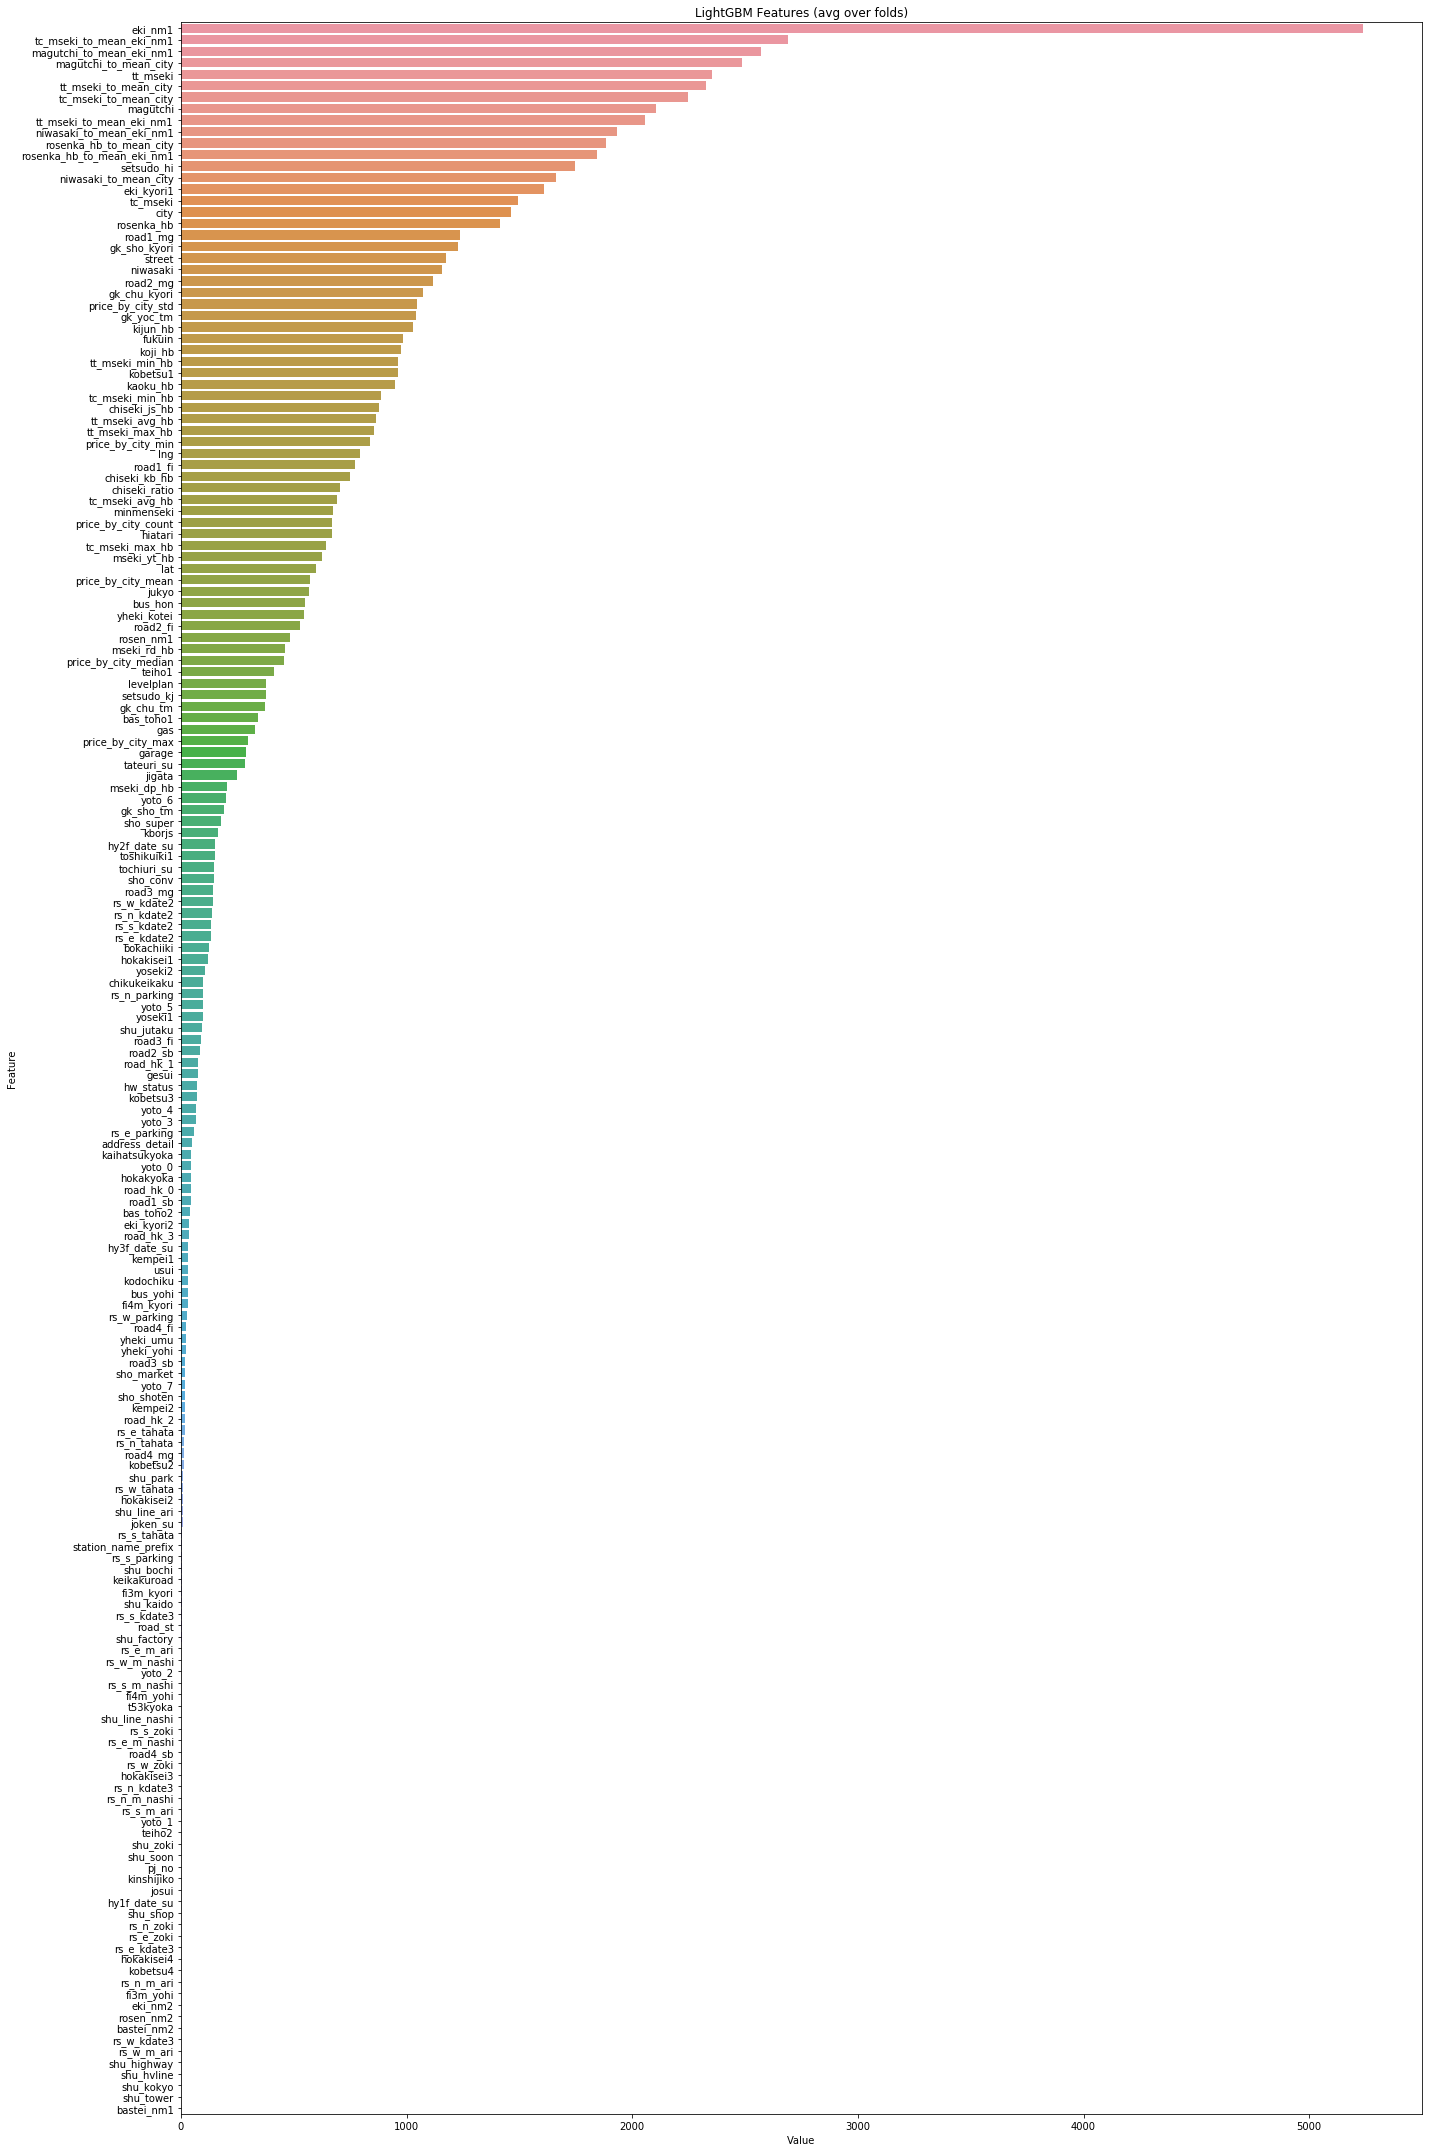

In [8]:
tmp = list(df_train)
tmp.remove('keiyaku_pr')
feature_imp = pd.DataFrame(sorted(zip(np.mean(feature_importance_list, axis=0), tmp)), columns=['Value','Feature'])

plt.figure(figsize=(20, 30))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()